Hi, everyone! I propose an original solution to one of the most well-known machine learning problems - Iris Species using a spiking neural network (SNN), with a test accuracy of 100%. In my work, I will not use well-known ready-made solutions in python related to SNN. **All the code is written by me from scratch, using only NumPy and Pandas**. I will use one of the most popular models of spiking neurons - the leaky integrate-and-fire (LIF) neuron model, or a threshold integrator neuron with leakage. For data transformation, I will use phase encoding with Gaussian receptive fields. I hope my code will be useful for those who are just starting to be interested in SNN. The notebook will give a general idea of how spiking neural networks work and one of the many ways to encode input information for use in SNN. I will not delve too deeply into the theoretical part, trying to convey the essence of the approach as concisely as possible. The list of sources I have prepared will help those who want to delve deeper into the topic.

Let's get started!

In general, our simplest network will have the following architecture:

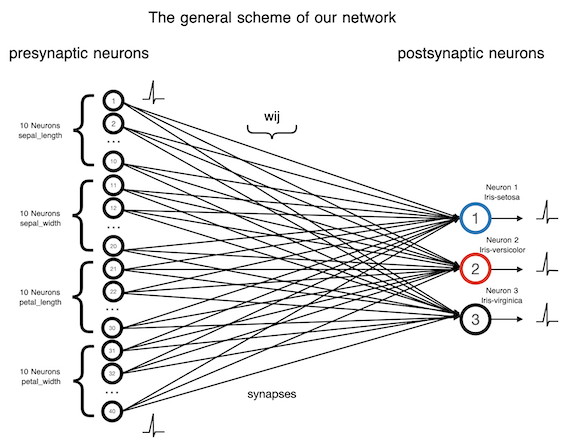

The dataset contains three types of flowers: Versicolor, Setosa, and Virginica.
Each class contains 4 features: "Sepal Length", "Sepal Width", "Petal Length", "Petal Width".
The goal of iris flower classification is to predict the flower types based on their specific features.
We will encode the values of each feature using 10 presynaptic neurons, for a total of 40 neurons.
In the output layer, we will have 3 postsynaptic neurons for each type of flower.

But how does it work?
Neurons are connected to each other by synapses with a certain weight, and tuning these weights is our main task, which we will solve below. The main essence of the model: presynaptic neurons (input information) generate spikes that stimulate postsynaptic neurons -> membrane potential (Vm) of postsynaptic neurins is rising -> postsynaptic neurons generate their spikes from this (output information). The postsynaptic neuron that fires first on a given input layer (period 10ms) is the predicted type of color that our impulse network.

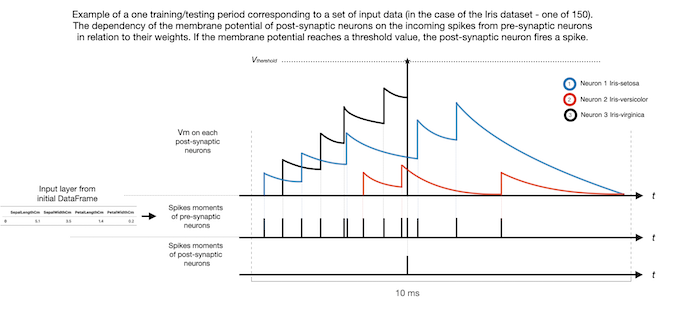

Now let's go over it again, but in a bit more detail, and then we can start writing the code.

The change in the re-ostsynaptic neuron's membrane potential depends on the timing of spikes from presynaptic neurons and the weight of the synapse between them. If there are no spikes coming from the presynaptic neurons, the postsynaptic neuron's membrane potential tends towards the resting potential (in our case, this is 0). The spike itself is an elementary event in the universe of SNN.

When the membrane potential of postsynaptic neuron reaches a threshold value, the postsynaptic neuron fires a spike. All of this happens during each training and testing period, which we take to be 10ms - the training period being the time during which all **active** presynaptic neurons corresponding to the values of the four input data features generate their spikes (there are a total of 150 such periods in the dataset). The postsynaptic neuron can either generate a spike or not. The postsynaptic neuron that fires a spike before any of the other postsynaptic neurons is considered to have fired during that period, while the others have not. After generating a spike, the postsynaptic neuron's potential falls back to the resting potential and does not change again until the end of the current training period (it cannot fire more than once on a single set of input data).

Great! We've covered all the basics. Now let's move on to the first part, which is encoding the original dataset to obtain the spike timing of the presynaptic neurons, or rather their latency. I would like to note that this ready-made dataset is available [here](https://www.kaggle.com/datasets/patrickstarrrr/iris-dataset-encoded-by-gaussian-receptive-fields).

Import all the necessary packages for work:

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
import warnings
warnings.filterwarnings("ignore")

from utils.functions import Gaus_neuron, LIF_SNN

Load the original dataset from any convenient source:

In [2]:
URL = 'Iris.csv'

df = pd.read_csv(URL)
df = df.iloc[:,1:]

Look at the first few lines of the dataset:

In [3]:
df.head()

,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm,Species
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa


In [4]:
df.loc[100]

SepalLengthCm               6.3
SepalWidthCm                3.3
PetalLengthCm               6.0
PetalWidthCm                2.5
Species          Iris-virginica
Name: 100, dtype: object

Make a copy of the dataframe, delete the 'species' column, leaving only the quantitative part of the detaset:

In [30]:
df_ = df.drop(columns=['Species']).copy()
df_

,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2
3,4.6,3.1,1.5,0.2
4,5.0,3.6,1.4,0.2
...,...,...,...,...
145,6.7,3.0,5.2,2.3
146,6.3,2.5,5.0,1.9
147,6.5,3.0,5.2,2.0
148,6.2,3.4,5.4,2.3


Build a data histogram:

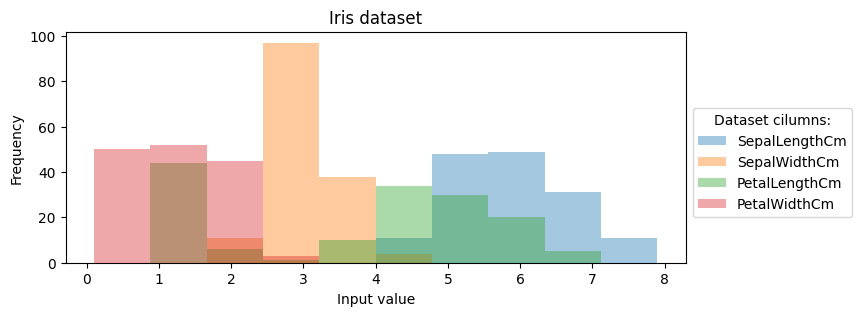

In [6]:
df_.plot.hist(alpha = 0.4, figsize = (8, 3))
plt.legend(title = "Dataset cilumns:" ,bbox_to_anchor = (1.0, 0.7), loc = 'upper left')
plt.title('Iris dataset', fontsize = 12)
plt.xlabel('Input value', fontsize = 10)
plt.show()

The data is distributed fairly evenly, which is why we will encode each feature with the 10 presynaptic neurons with same size, resulting in a total of 10 x 4 = 40 presynaptic neurons.

Select the parameters for uniform coverage of the range of possible values of each feature by Gaussians and apply the function written above:

In [31]:
sigm = [0.1, 0.1, 0.2, 0.1]
d = Gaus_neuron(df_, 10, 0.001, sigm)

([array([[1.000000, 0.999950, 0.999800, ..., 0.000000, 0.000000, 0.000000],
         [0.000335, 0.000349, 0.000363, ..., 0.000000, 0.000000, 0.000000],
         [0.000000, 0.000000, 0.000000, ..., 0.000000, 0.000000, 0.000000],
         ...,
         [0.000000, 0.000000, 0.000000, ..., 0.000000, 0.000000, 0.000000],
         [0.000000, 0.000000, 0.000000, ..., 0.000363, 0.000349, 0.000335],
         [0.000000, 0.000000, 0.000000, ..., 0.999800, 0.999950, 1.000000]]),
  array([[1.000000, 0.999950, 0.999800, ..., 0.000000, 0.000000, 0.000000],
         [0.028566, 0.029336, 0.030124, ..., 0.000000, 0.000000, 0.000000],
         [0.000001, 0.000001, 0.000001, ..., 0.000000, 0.000000, 0.000000],
         ...,
         [0.000000, 0.000000, 0.000000, ..., 0.000001, 0.000001, 0.000001],
         [0.000000, 0.000000, 0.000000, ..., 0.030124, 0.029336, 0.028566],
         [0.000000, 0.000000, 0.000000, ..., 0.999800, 0.999950, 1.000000]]),
  array([[1.000000, 0.999988, 0.999950, ..., 0.000000, 0

Now visualize Gaussians for our dataset for each input feature:

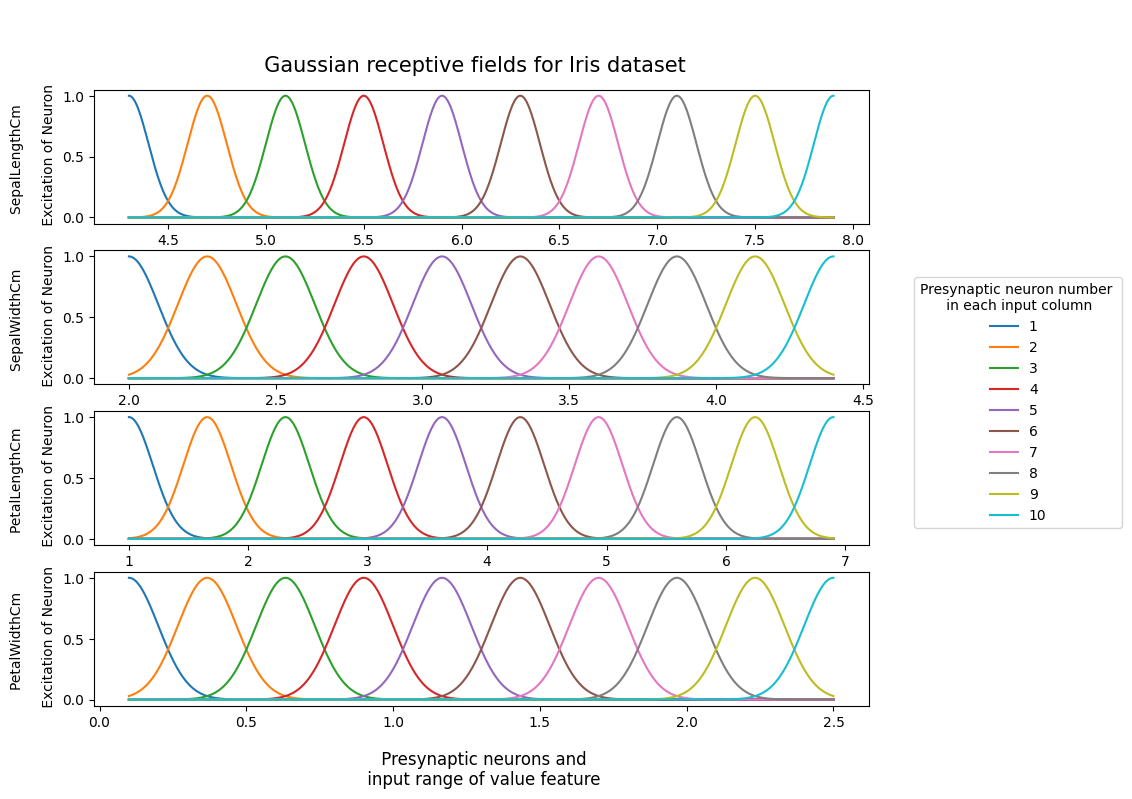

In [8]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4)

fig.set_figheight(8)
fig.set_figwidth(10)

k = 0

for ax in [ax1, ax2, ax3, ax4]:

    ax.set(ylabel = f'{df_.columns[k]} \n\n Excitation of Neuron')

    for i in range(len(d[0][k])):

        ax.plot(d[1][k], d[0][k][i], label = i + 1)

    k+=1

plt.legend(title = "Presynaptic neuron number \n      in each input column" ,bbox_to_anchor = (1.05, 3.25), loc = 'upper left')
plt.suptitle(' \n\n  Gaussian receptive fields for Iris dataset', fontsize = 15)
ax.set_xlabel(' Presynaptic neurons and\n input range of value feature', fontsize = 12, labelpad = 15)


plt.show()

Now let's examine the encoding logic in detail using the first five data points of the "SepalWidthCm" feature as an example: We will draw dotted vertical segments for the first five values of the "SepalWidthCm" feature and locate their intersections with the Gaussian presynaptic neurons. These points will be marked with red dots:

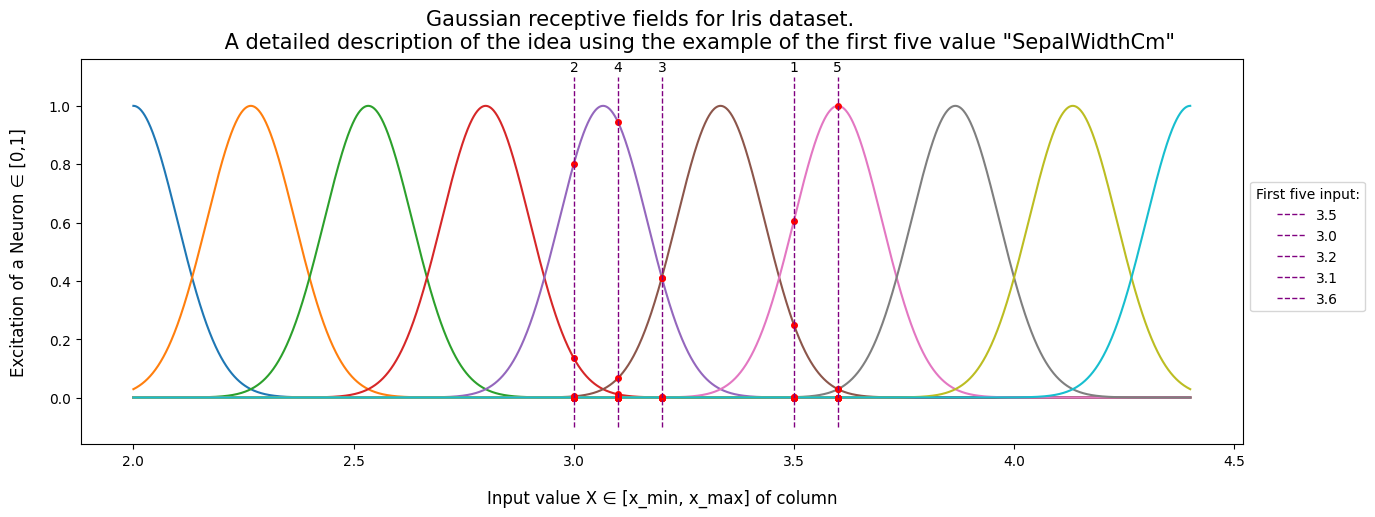

In [9]:
x_input = 5
fig, ax = plt.subplots(1)

fig.set_figheight(5)
fig.set_figwidth(15)

ax.set(ylabel = df_.columns[1])

for i in range(len(d[0][1])):
    ax.plot(d[1][1], d[0][1][i])

for n in range(x_input):

    plt.plot(np.tile(df_['SepalWidthCm'][n], (10,1)), 
         d[0][1][np.tile(d[1][1] == df_['SepalWidthCm'][n], (10,1))], 'ro', markersize=4)

    plt.vlines(x = df_['SepalWidthCm'][n], ymin = - 0.1, ymax = 1.1, 
               colors = 'purple', ls = '--', lw = 1, label = df_['SepalWidthCm'][n])

    plt.text(df_['SepalWidthCm'][n] * 0.997, 1.12, n + 1, size = 10)


plt.legend(title = "First five input:", bbox_to_anchor = (1.0, 0.7), loc = 'upper left')

plt.suptitle('Gaussian receptive fields for Iris dataset. \n \
                A detailed description of the idea using the example of the first five value "SepalWidthCm"',
            fontsize = 15)

ax.set_xlabel('Input value X ∈ [x_min, x_max] of column', fontsize = 12, labelpad = 15)
ax.set_ylabel('Excitation of a Neuron ∈ [0,1]', fontsize = 12, labelpad = 15)

plt.show()

Now output the numerical values of the intersection points of the input of each value with each Gaussian (presynaptic neuron):

In [10]:
np.set_printoptions(formatter={'float_kind':'{:f}'.format})
five_x = np.zeros((5, 10))

for n in range(x_input):
    five_x[n,:] = d[0][1][np.tile(d[1][1] == df_['SepalWidthCm'][n], (10,1))]

five_x

array([[0.000000, 0.000000, 0.000000, 0.000000, 0.000084, 0.249354,
        0.606531, 0.001204, 0.000000, 0.000000],
       [0.000000, 0.000000, 0.000019, 0.135335, 0.800742, 0.003866,
        0.000000, 0.000000, 0.000000, 0.000000],
       [0.000000, 0.000000, 0.000000, 0.000335, 0.411115, 0.411115,
        0.000335, 0.000000, 0.000000, 0.000000],
       [0.000000, 0.000000, 0.000000, 0.011109, 0.945965, 0.065729,
        0.000004, 0.000000, 0.000000, 0.000000],
       [0.000000, 0.000000, 0.000000, 0.000000, 0.000001, 0.028566,
        1.000000, 0.028566, 0.000001, 0.000000]])

Let's find the latency of each presynaptic neuron as 1 - (excitation of the presynaptic neuron), provided that the excitation of the neuron is greater than 0.1, otherwise we consider the presynaptic neuron to be unexcited at this iteration:

In [11]:
five_x = np.where(five_x > 0.1, 1 - five_x, np.nan)
five_x[five_x == 0] = 0.0001
five_x

array([[nan, nan, nan, nan, nan, 0.750646, 0.393469, nan, nan, nan],
       [nan, nan, nan, 0.864665, 0.199258, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, 0.588885, 0.588885, nan, nan, nan, nan],
       [nan, nan, nan, nan, 0.054035, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, 0.000100, nan, nan, nan]])

Now let's visualize the process of spike occurrence taking into account the latency. Black dots on the graph - the moment the spike is emitted by the presynaptic neuron:

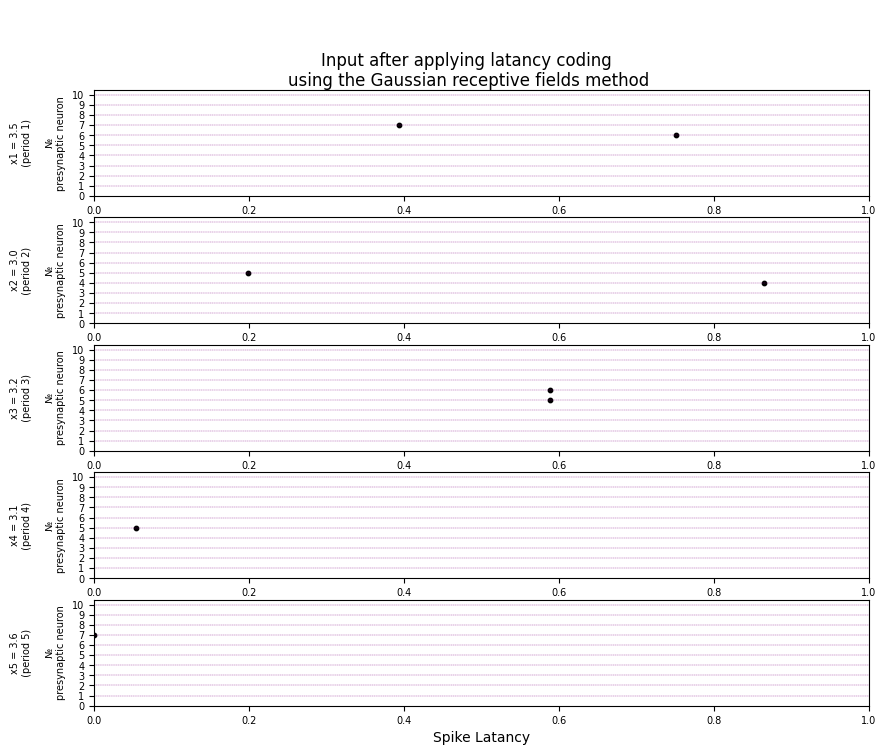

In [12]:
fig, ax = plt.subplots(5, figsize=(10, 8))

for i in range(5):
    ax[i].scatter(x = five_x[i], y = np.arange(1, 10 + 1), s = 10, color = 'black')
    ax[i].hlines(xmin = 0, xmax=1, y=np.arange(1, 11, 1),
               colors = 'purple', ls = '--', lw = 0.25)
    ax[i].yaxis.set_ticks(np.arange(0, 11, 1))
    ax[i].set_ylabel(f'x{i+1} = {df_.iloc[i,1]}\n (period {i+1}) \n\n № \npresynaptic neuron', fontsize = 7)
    ax[i].set_xlim(0, 1)
    ax[i].set_ylim(0, 10 * 1.05)
    ax[i].tick_params(labelsize = 7)

ax[i].set_xlabel('Spike Latancy')
plt.suptitle(' \n\nInput after applying latancy coding \nusing the Gaussian receptive fields method', fontsize = 12)
plt.show()

Now we will do this for all values of all features:

In [13]:
def Lat_Spike(df, d, n):

    for i in range(len(df.columns)):

        k = len(df.iloc[:, i])
        st1 = np.tile(d[1][i], (k, 1))
        st2 = df.iloc[:, i].values.reshape(-1, 1)
        ind = (st1 == st2)
        exc = np.tile(d[0][i], (k, 1)).reshape(k, n, len(d[0][i][0]))[
            np.repeat(ind, n, axis=0).reshape(k, n, len(ind[0]))].reshape(k, n)
        lat_neuron = np.transpose(np.where(exc > 0.1, 1 - exc, np.nan))

        if i == 0:
            lat_neuron_total = lat_neuron
        else:
            lat_neuron_total = np.concatenate((lat_neuron_total, lat_neuron), axis = 0)

    lat_neuron_total[lat_neuron_total == 0] = 0.0001

    return lat_neuron_total

fin = Lat_Spike(df_, d, 10)

Visualize the moments of spike generation by presynaptic neurons for the first value of each of the four features:

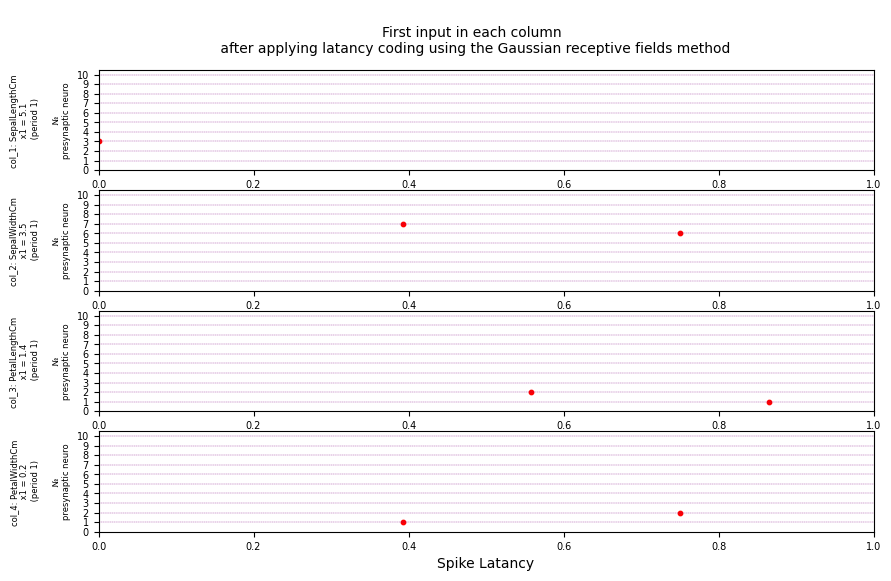

In [28]:
fig, ax = plt.subplots(4, figsize=(10, 6))

for i in range(4):

    ax[i].scatter(x = fin[i * 10:10 * (1 + i), 0], y = np.arange(1, 10 + 1), s = 10, color = 'r')
    ax[i].hlines(xmin = 0, xmax = 1, y=np.arange(1, 11, 1), 
               colors = 'purple', ls = '--', lw = 0.25)
    ax[i].yaxis.set_ticks(np.arange(0, 11, 1))
    ax[i].set_ylabel(f'col_{i + 1}: {(df_.columns)[i]} \n x1 = {df_.iloc[0, i]} \n (period {1})\n\n № \npresynaptic neuro', fontsize = 6)
    ax[i].set_xlim(0, 1)
    ax[i].set_ylim(0, 10 * 1.05)
    ax[i].tick_params(labelsize = 7)

ax[i].set_xlabel('Spike Latancy')
plt.suptitle('\nFirst input in each column \n after applying latancy coding using the Gaussian receptive fields method', fontsize = 10)
plt.show()

All right, now present the results in the form of a DataFrame. By rows - presynaptic neurons, by columns - the number of the input data set: 

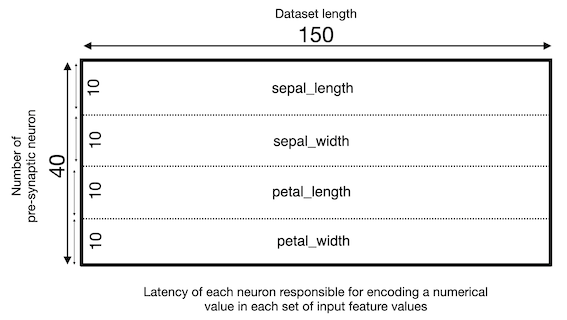

In [14]:
Final_df = pd.DataFrame(fin)
Final_df

,0,1,2,3,4,5,6,7,8,9,...,140,141,142,143,144,145,146,147,148,149
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.393469,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,0.864665,0.000100,0.393469,NaN,NaN,0.393469,NaN,NaN,0.864665,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0.000100,0.864665,NaN,NaN,0.393469,NaN,NaN,0.393469,NaN,0.864665,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,0.393469,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,0.393469,NaN,NaN,NaN,NaN,NaN,NaN,0.000100
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.000100,0.864665,0.393469,NaN
6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.000100,0.864665,NaN,0.393469,0.000100,0.000100,NaN,0.864665,NaN,NaN
7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,0.864665,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Let's visualize the obtained latencies for the first three learning periods, considering one period to be equal to 10 ms, therefore, we will scale the latency of each presynaptic neuron (total time interval by three periods is 30 ms):

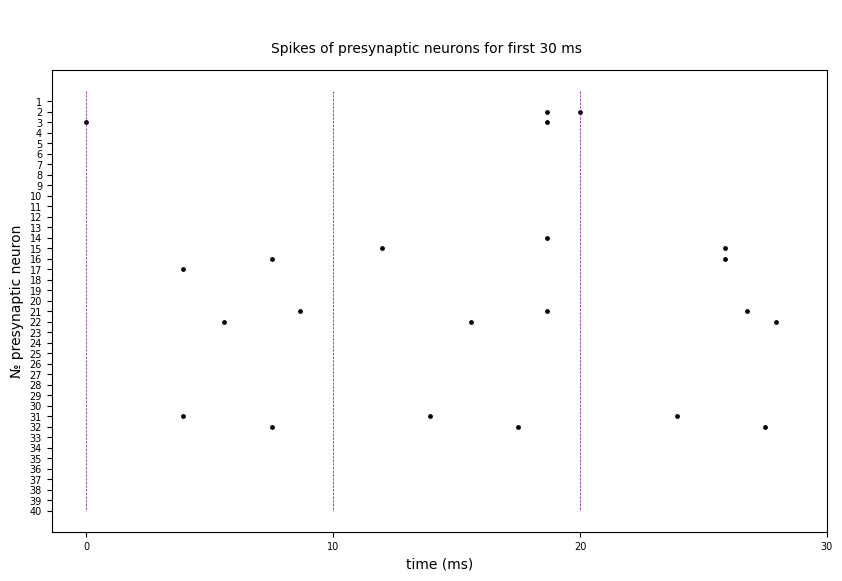

In [15]:
fig, ax = plt.subplots(1, figsize=(10, 6))
h = 3

for i in range(h):
    ax.scatter(x = (i+Final_df.iloc[:,i].values)*10, y = np.arange(1, 41), s = 6, color = 'black')

    plt.vlines(x = (i) * 10, ymin = 0, ymax = 40, 
               colors = 'purple', ls = '--', lw = 0.5)
    ax.tick_params(labelsize = 7)

ax.yaxis.set_ticks(np.arange(1, 41, 1))
ax.xaxis.set_ticks(np.arange(0, (h+1)*10, 10))
ax.set_xlabel('time (ms)')
ax.set_ylabel('№ presynaptic neuron')
plt.suptitle(' \n\nSpikes of presynaptic neurons for first 30 ms', fontsize = 10)
plt.gca().invert_yaxis()
plt.show()

Great! We've encoded our dataset successfully!

I repeat, I would like to note that this ready-made dataset is available [here](https://www.kaggle.com/datasets/patrickstarrrr/iris-dataset-encoded-by-gaussian-receptive-fields).

Now let's move on to training our LIF neuron!

Before we write our own LIF neuron model, it is important to understand how synapse weights are formed, which I described at the beginning of this notebook. After we split our dataset into training (size of 120 out of 150: 40 for each flower type) and testing sets, we will train our model by adjusting the weights of synaptic connections. To do this, we will divide the training into two parts. 

**Part one**. Subsample size of 60: the first 20 values for each flower type.

The data in the original data set are distributed sequentially by iris types: a total of 150 data sets of which the first 50 records belong to Iris-setosa, 50-100 - Iris-versicolor, 100-150 - Iris-virginica. I writen a function that will select the data set we need from the portfolio, in which there will be an equal number of instances of each type:

In [16]:
def model_data(ind, ind_type, lat_ne, start, end):
    
    train_stack = np.vstack((lat_ne[ind_type[ind, 0] + start:ind_type[ind, 0] + end],
                            lat_ne[ind_type[ind, 1] + start:ind_type[ind, 1] + end],
                            lat_ne[ind_type[ind, 2] + start:ind_type[ind, 2] + end]))
    train_stack = np.where(train_stack > 0, train_stack, 0)
    
    return train_stack

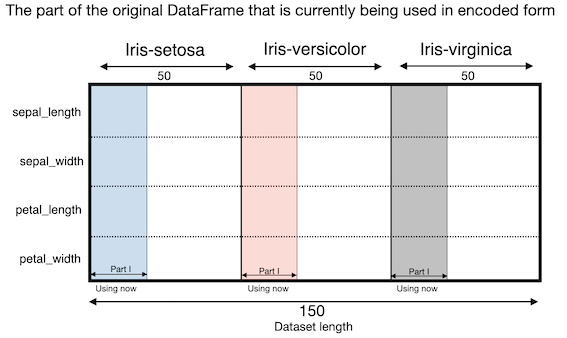

At the first stage, we need to somehow increase the weights of active synapses, forming a set of weights for each postsynaptic neuron for further correction using STDP (Spike-timing-dependent plasticity) at the second stage. How can we do this? There can be many options, here are the basic principles of weight gain that I will use for the first part of the training set:
1. All weights are initially equal to 0.1
2. For each postsynaptic neuron in the training period **corresponding to its flower type**, we increase the weights of all active presynaptic neurons by a constant that is the same for all, adjusted depending on the delay of the specific presynaptic neuron: less delay -> presynaptic neuron generated a spike earlier -> receives a greater weight. The general formula is as follows: delta_weight = +Const * (1 - latency)
3. For each postsynaptic neuron in the training period **not corresponding to its flower type**, we impose a penalty on all active presynaptic neurons that have a weight that is not the default (weight > 0.1). That is, we "penalize" presynaptic neurons that fire for different types of flowers, reducing their weights -> reducing their contribution to the stimulation of the membrane potential of postsynaptic neurons of other flower types. Similarly to point 2, the size of the penalty is equal to the same constant, adjusted for the delay of the active neuron in this training period. The general formula is as follows: delta_weight = -Const * (1 - latency)
4. The "penalty" from point 3 is evenly distributed among non-active presynaptic neurons in this period that have a weight that is not the default (weight > 0.1). The general formula is as follows: delta_weight = -Const * (1 - latency) / N, where latency is the delay of the fired presynaptic neuron, N is the number of "silent" presynaptic neurons with a weight greater than the default
5. Adjusted weights cannot be less than the default value: if the weight decreases, then 0.1 is the lower limit. We **do not have "braking"** presynaptic neurons with negative connection weights
6. In each iteration (each period), connections with default weights are not corrected in any way

Phew! If I confused you a little, the picture below will help you understand:

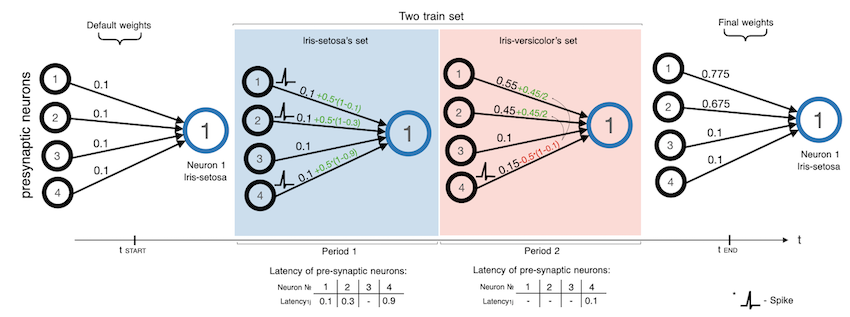

In [17]:
lat_ne = np.transpose(Final_df.values)
ind_type = np.array(([0, 50, 100], [50, 100, 0], [100, 0, 50]))
list_weight = np.zeros((3,40))

for ind in range(3):
    
    train_stack = model_data(ind, ind_type, lat_ne, 0, 20)
    tr_ar = np.where(np.transpose(train_stack) > 0, 2 * (1 - np.transpose(train_stack)), 0)
    tr_ar[:, 20:] = tr_ar[:, 20:] * (-1)
    tr_ar = pd.DataFrame(tr_ar)
    tr_ar[20] = tr_ar.iloc[:,:20].sum(axis = 1) + 0.1
    tst_ar = np.float64(np.transpose(np.array(tr_ar.iloc[:,20:])))
    
    for i in range(1, len(tst_ar)):
        
        tst_ar[0][((np.round(tst_ar[0], 4) > 0.1) & (tst_ar[i] == 0))] += - np.float64(
            np.sum(tst_ar[i][np.round(tst_ar[0], 4) > 0.1]) / len(tst_ar[0][((
                np.round(tst_ar[0], 4) > 0.1) & (tst_ar[i] == 0))]))
        tst_ar[0][np.round(tst_ar[0], 4) > 0.1] += tst_ar[i][np.round(tst_ar[0], 4) > 0.1]
        tst_ar[0][tst_ar[0] < 0.1] = 0.1
        
    list_weight[ind, :] = tst_ar[0]

list_weight

array([[6.327651, 9.871060, 8.845120, 0.100000, 0.100000, 0.100000,
        0.100000, 0.100000, 0.100000, 0.100000, 0.100000, 0.100000,
        0.100000, 0.100000, 0.100000, 2.928582, 7.467641, 9.633854,
        3.937019, 5.114590, 9.286149, 24.821730, 0.100000, 0.100000,
        0.100000, 0.100000, 0.100000, 0.100000, 0.100000, 0.100000,
        22.327485, 20.183585, 0.100000, 0.100000, 0.100000, 0.100000,
        0.100000, 0.100000, 0.100000, 0.100000],
       [0.100000, 0.100000, 0.100000, 7.079353, 3.988910, 4.650976,
        4.987558, 0.100000, 0.100000, 0.100000, 8.024717, 10.069888,
        0.100000, 3.975590, 0.100000, 0.100000, 0.100000, 0.100000,
        0.100000, 0.100000, 0.100000, 0.100000, 0.100000, 6.758999,
        12.650149, 17.925515, 0.100000, 0.100000, 0.100000, 0.100000,
        0.100000, 0.100000, 0.100000, 11.383210, 13.145523, 25.117006,
        0.100000, 0.100000, 0.100000, 0.100000],
       [0.100000, 0.100000, 0.100000, 0.100000, 1.051971, 5.704924,
        4

We have obtained our first set of weights! Let's write a function for our neuron that takes into account the synaptic weights and spike timings of presynaptic neurons. Then we will see how the membrane potential of each postsynaptic neuron behaves.

But first, let's introduce the formula for changing the membrane potential of a postsynaptic neuron. Simply put: a spike with the weight of the synapse arrives at the postsynaptic neuron -> the membrane potential of the postsynaptic neuron increases, and if no spikes arrive, the potential drops to its minimum level (in our case, this is 0) - this logic is visible in the following formula:

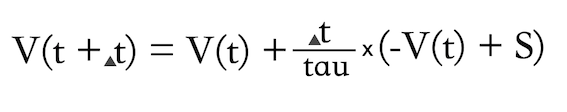

this formula is a slightly modified and simplified version of formula from [12], but all the logic of the classic LIF neuron is preserved here. In my formula, the resting potential is absent because I assume it to be equal to 0. Input parameters such as tau, dt, Vmin can be chosen to approximate the model to the biological neuron model. In this case, I do not have such a task, so the parameters are chosen to be as clear and functional as possible. Now let's implement this logic in code:

Function for visualizing spike moments of postsynaptic neurons:

In [18]:
def spike_plot(spike_times, one_per, n, cur_type):
    
    fig, (ax1, ax2, ax3) = plt.subplots(3, figsize = (25, 10))#, dpi = 70)
    
    if one_per:
        k, t, a  = 1, n, 0
        cur = cur_type
    else:
        k, t, a = len(spike_times[0]), 0, 1
        cur = 1
        
    spike_times[spike_times == 0] = np.nan
    di = {0: 'blue', 1: 'red', 2: 'black'}
    di_t = {0: 'Iris-setosa', 1: 'Iris-versicolor', 2: 'Iris-virginica'}
    p = 0
    
    for ax in [ax1, ax2, ax3]:
        for i in range(k * t, k + t):
            ax.vlines(x = spike_times[p, i] / 100 + i * a * 10, ymin = 0.0, ymax = 1.1, 
                       colors = di[p], ls = '-', lw = 3)
            ax.set_ylabel(f'Neuron {p + 1} \n {di_t[p]}', fontsize = 15)
            
        if one_per:
            ax.axvspan(0, int(k * 10), color = di[cur - 1], alpha = 0.05, label = di_t[cur - 1])
            ax.margins(0)
        else:
            ax.axvspan(0, int(k * 10 / 3), color = di[0], alpha = 0.05, label = di_t[0])
            ax.axvspan(int(k * 10 / 3), int(k * 10 * 2 / 3), color = di[1], alpha = 0.05, label = di_t[1])
            ax.axvspan(int(k * 10 * 2 / 3), int(k * 10 * 3 / 3), color = di[2], alpha = 0.05, label = di_t[2])
            ax.set_xlim(0, k * 10)
            ax.margins(0)
            
        p += 1
        
    if one_per:
        plt.suptitle(f' \n\n Moment of spike of postsynaptic neurons for train period {n}', fontsize = 20)
        plt.legend(title = "    Part of a type set:" ,bbox_to_anchor = (1, 1.9), loc = 'upper left',
               fontsize = 15, title_fontsize = 15)
    else:
        plt.suptitle(f' \n\n Moment of spike of postsynaptic neurons on the used part of the dataset', fontsize = 20)
        plt.legend(title = "    Part of a type set:" ,bbox_to_anchor = (1, 2.1), loc = 'upper left',
               fontsize = 15, title_fontsize = 15)
    
    plt.xlabel('Time (ms)', fontsize = 15)
    plt.show()

Function for visualizing membrane potential of each postsynaptic neuron:

In [19]:
def v_plot(v):
    
    fig, (ax1, ax2, ax3) = plt.subplots(3, figsize = (25, 10))#, dpi = 70)
    k = len(v[0,:,:])
    di = {0: 'blue', 1: 'red', 2: 'black'}
    di_t = {0: 'Iris-setosa', 1: 'Iris-versicolor', 2: 'Iris-virginica'}
    p = 0
    
    for ax in [ax1, ax2, ax3]:
        for i in range(k):
            ax.plot(np.arange(i * 10, (i + 1) * 10, 0.01), v[p, i, :], di[p], linewidth = 1)
            ax.set_ylabel(f' Neuron {p + 1} \n {di_t[p]} \nV (mV)', fontsize = 15)

        ax.axvspan(0, int(k * 10 / 3), color = di[0], alpha = 0.05, label = di_t[0])
        ax.axvspan(int(k * 10 / 3), int(k * 10 * 2 / 3), color = di[1], alpha = 0.05, label = di_t[1])
        ax.axvspan(int(k * 10 * 2 / 3), int(k * 10 * 3 / 3), color = di[2], alpha = 0.05, label = di_t[2])
        ax.margins(0)

        p += 1
    
    plt.legend(title = "    Part of a type set:" ,bbox_to_anchor = (1, 2), loc = 'upper left', fontsize = 15, title_fontsize = 15)
    plt.xlabel('Time (ms)', fontsize = 15)
    plt.suptitle(' \n Activity of postsynaptic neurons on the used part of the dataset \n (Membrane potential)', fontsize = 20)

Accuracy function. If multiple postsynaptic neurons generate spikes during one period, the postsynaptic neuron that generated the spike first is considered to have fired:

In [20]:
def accuracy_snn(spike_time, start, end, df, ind_type, ind):
    
    type_dict = {'Iris-setosa': 1, 'Iris-versicolor': 2, 'Iris-virginica': 3}
    target_type_total = np.array(df.replace({'Species': type_dict}).iloc[:, - 1])
    target_type = np.vstack((target_type_total[ind_type[ind, 0] + start:ind_type[ind, 0] + end],
                            target_type_total[ind_type[ind, 1] + start:ind_type[ind, 1] + end],
                            target_type_total[ind_type[ind, 2] + start:ind_type[ind, 2] + end])).flatten()
    
    spike_time_ = np.where(spike_time > 0, np.array(([1], [2], [3])), np.nan)
    final_test = np.full([len(spike_time[0])], np.nan).astype(int)
    for i in range(len(spike_time[0])):
        try:
            final_test[i] = spike_time_[:, i][spike_time[:, i] == np.min(spike_time[:, i][spike_time[:, i] > 0])][0]
        except:
            final_test[i] = 0
    
    ac = np.sum(np.where(final_test == target_type, 1, 0)) / len(target_type)

    return final_test, target_type, print('accur.:', np.round(ac * 100, 2), '%')

We adjusted and increased the weights on the first 20 instances of each type for each postsynaptic neuron, resulting in three sets of weights. Let's examine the membrane potential profile of each postsynaptic neuron with these obtained weights on the same first part of the training set. At this stage, we will not limit the membrane potential to a threshold level, choosing it to be equal to 100:

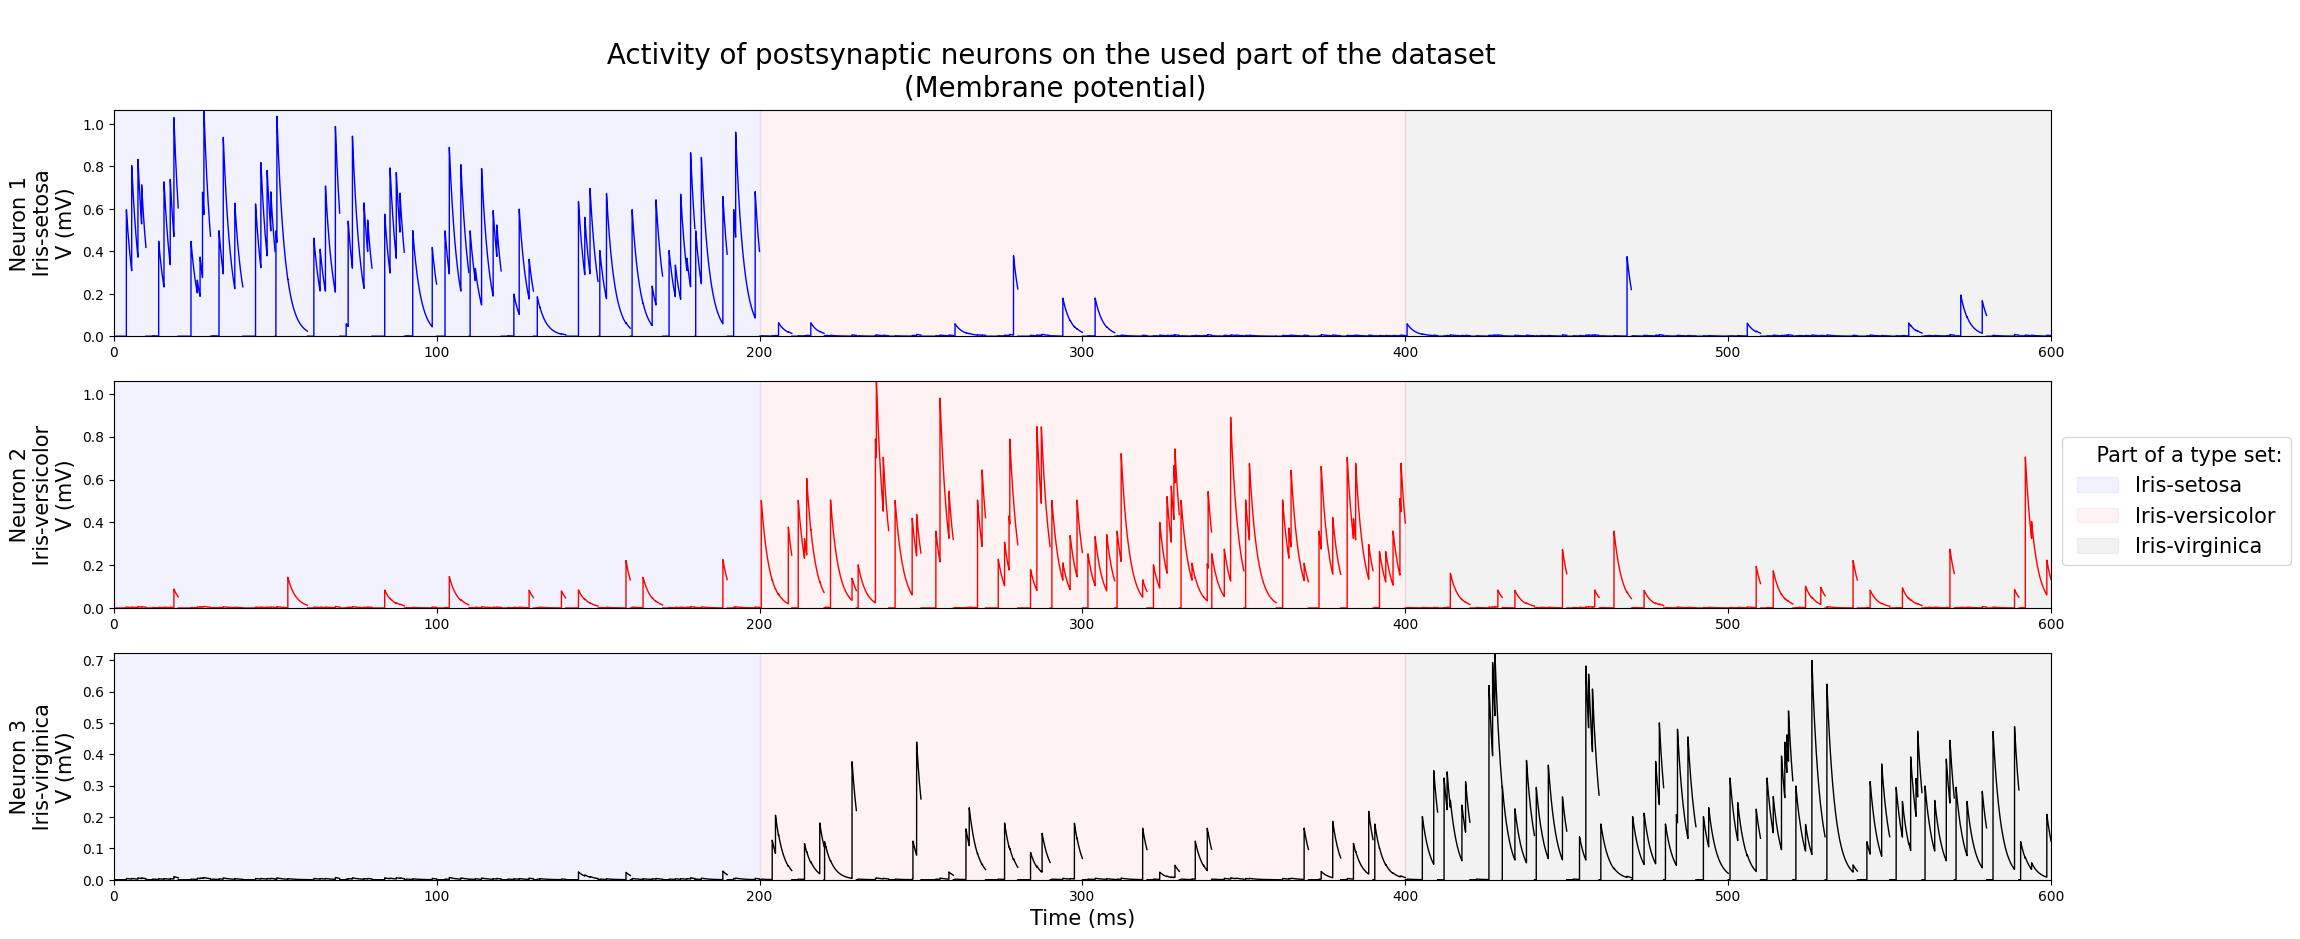

In [21]:
train_stack = model_data(0, ind_type, lat_ne, 0, 20)
res = LIF_SNN(3, 60, train_stack, list_weight, 100)
v = res[0]

v_plot(v)

Overall, it looks good, with each postsynaptic neuron's activity area clearly visible. The membrane potential profile of the first neuron looks the best, while neurons 2 and 3 are more responsive to "foreign" spikes that should not significantly change their potentials - this could lead to incorrect classification. Let's look at the spike times and accuracy at this stage with a threshold voltage value of 0.25:

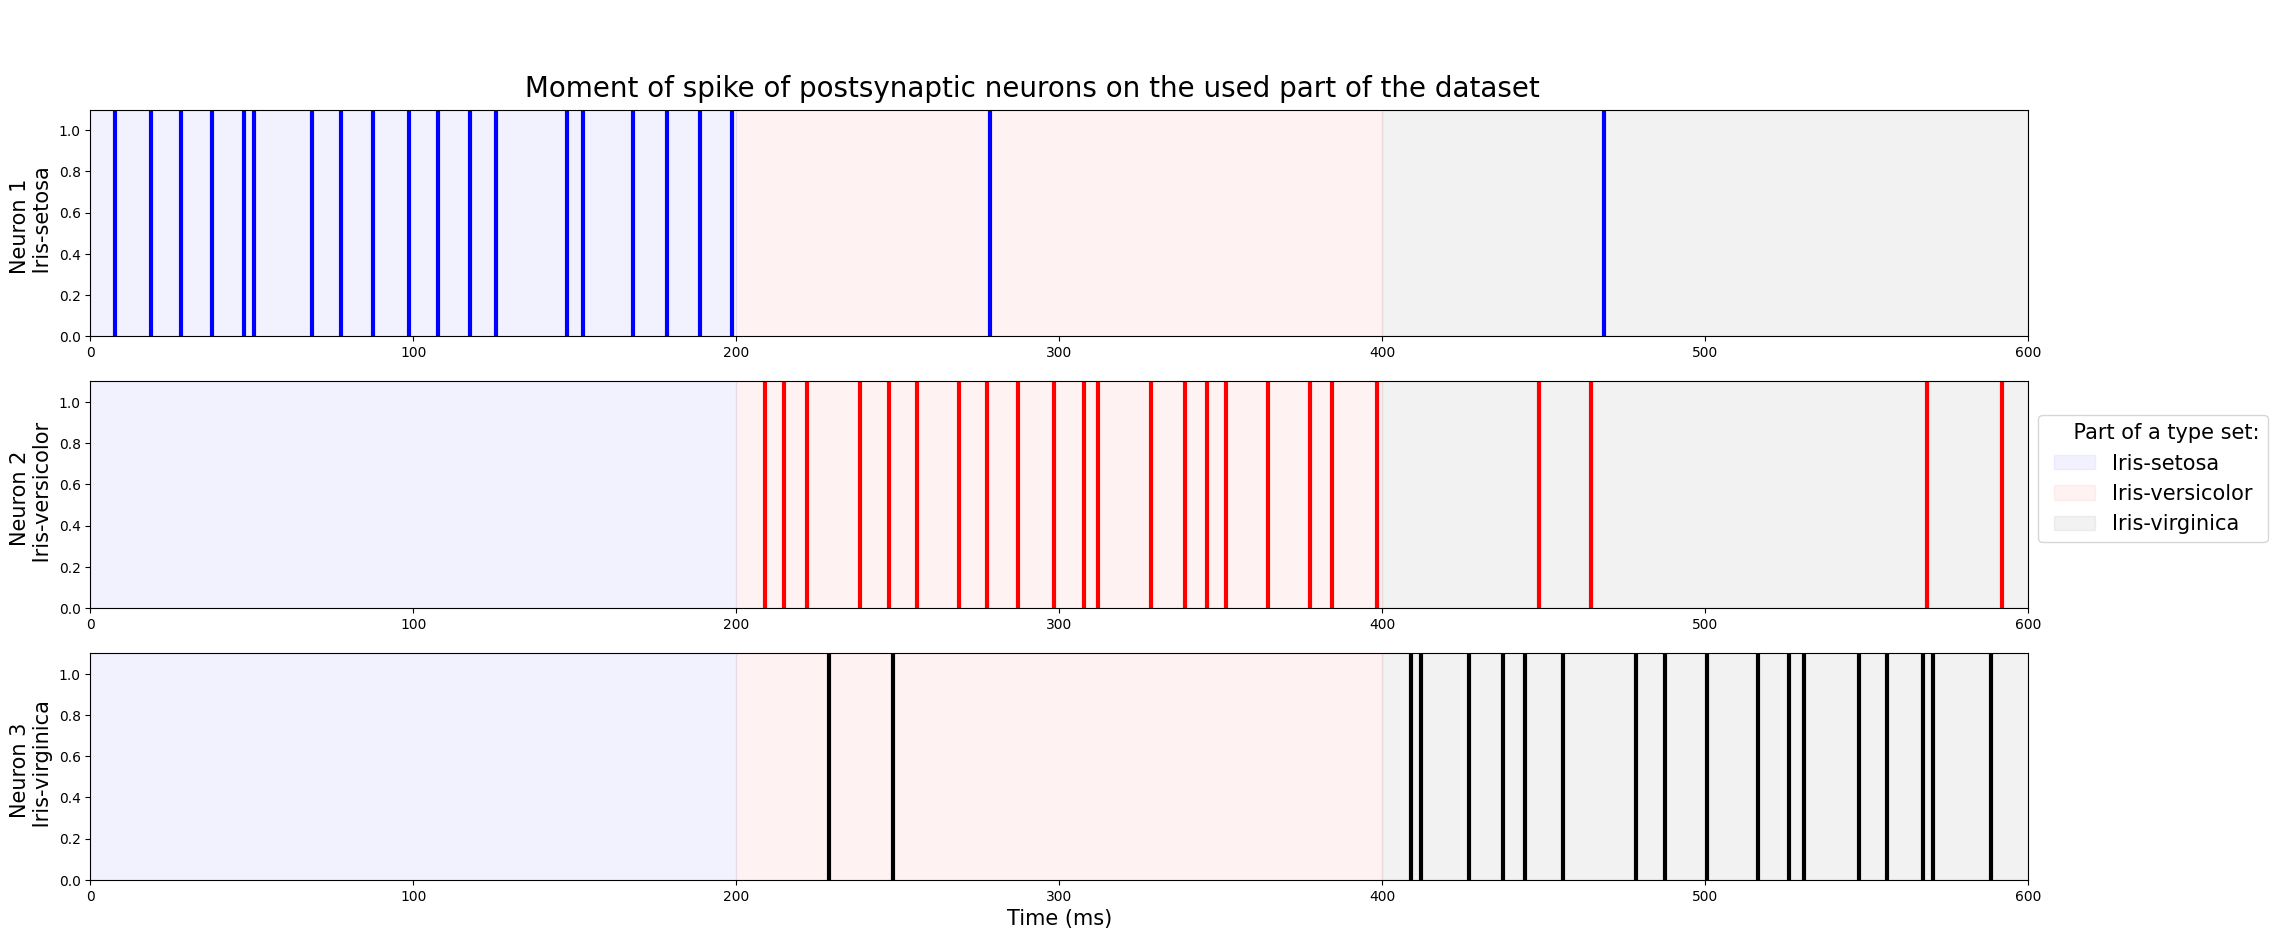

accur.: 93.33 %


In [22]:
res = LIF_SNN(3, 60, train_stack, list_weight, 0.25)
spike_time = res[2]
spike_plot(spike_time, False, False, False)
accuracy_snn(spike_time, 0, 20, df, ind_type, 0)[2]

The accuracy is good! Let's examine a few periods where one of the postsynaptic neurons has false activations. We'll try to understand what's happening and how it affects accuracy.

Let's look at the last false spike of the first postsynaptic neuron, which occurs in period 46 of the first part of training:

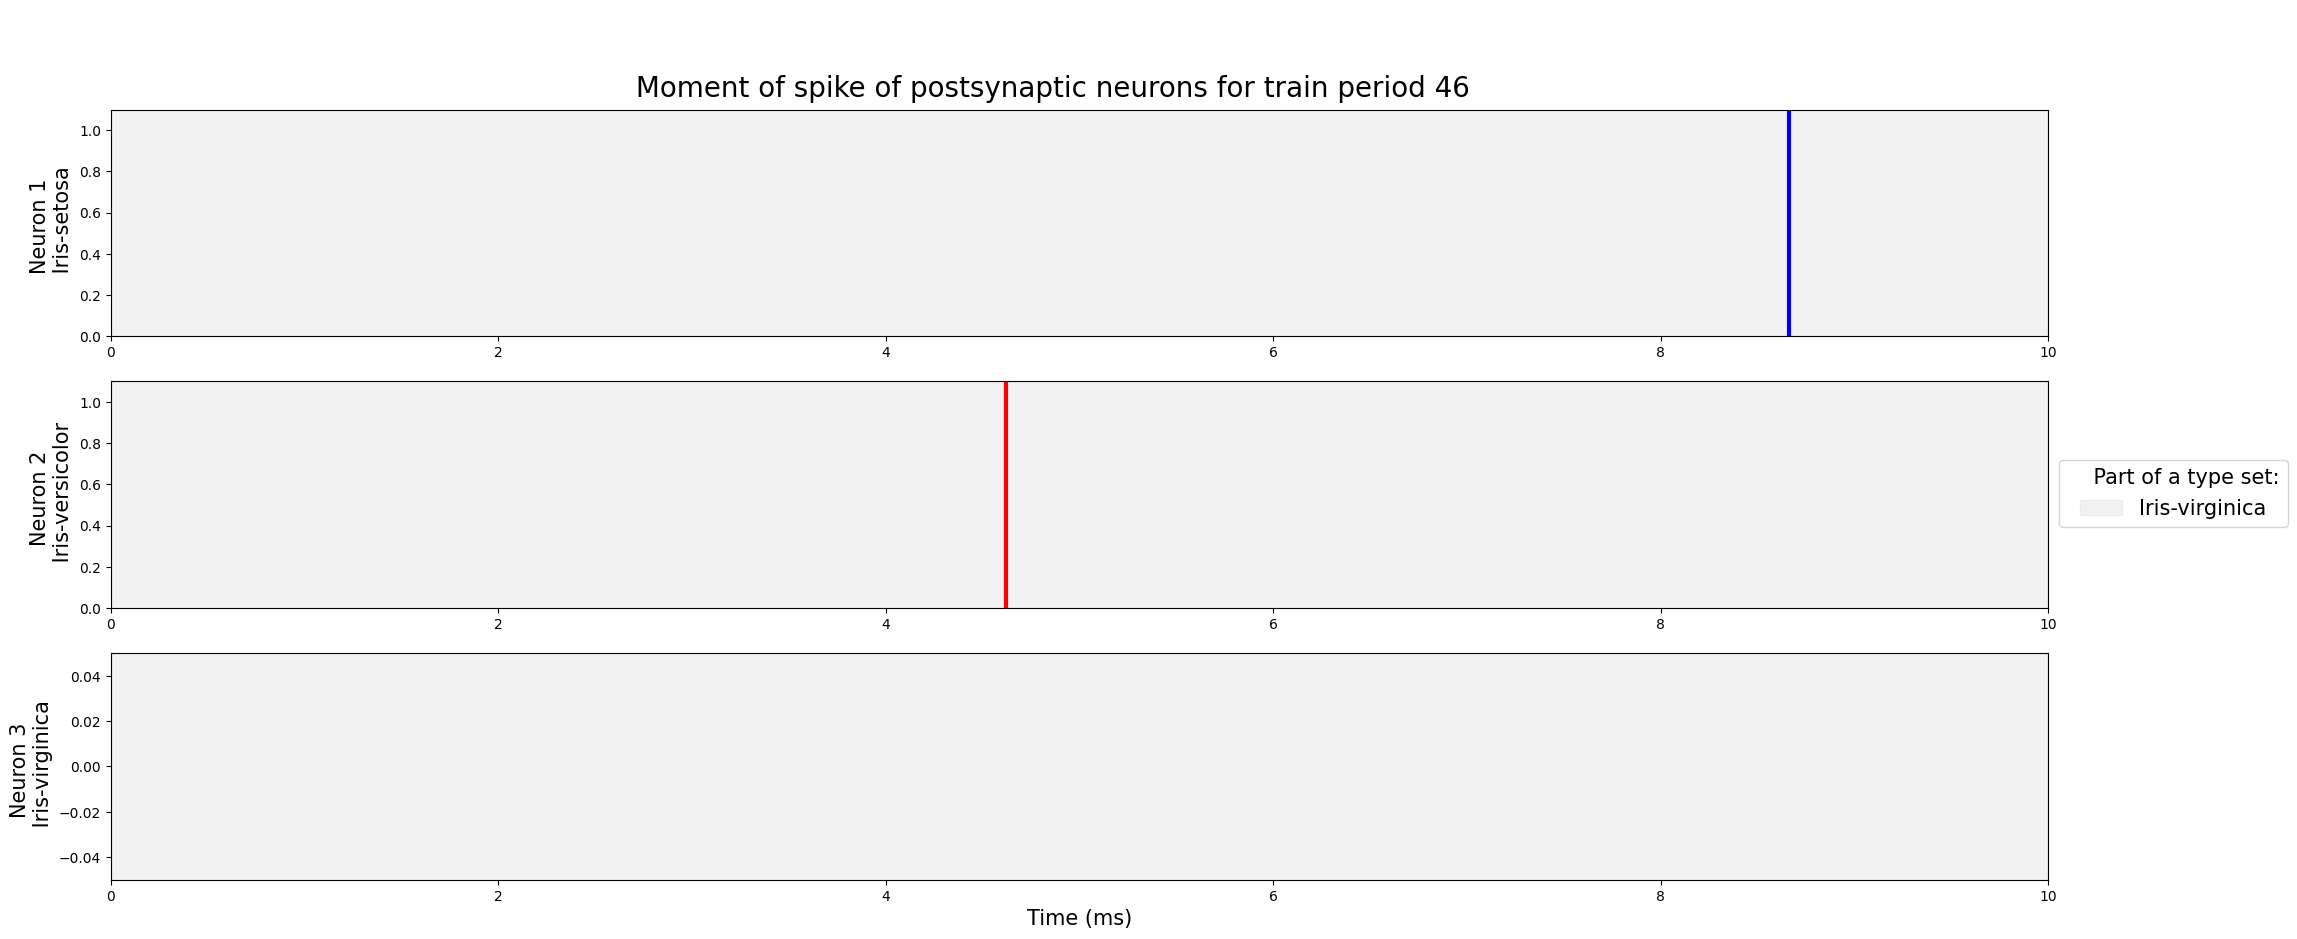

In [23]:
spike_plot(spike_time, True, 46, 3)

Together with the first incorrect spike, the second postsynaptic neuron spikes falsely, while the necessary third neuron remains silent. In this case, the second neuron will be recognized as having fired because it generated a spike earlier than the first - this is an error that reduces accuracy. 

Let's examine the second false spike of the third postsynaptic neuron, which occurs in period 24 of the first part of training:

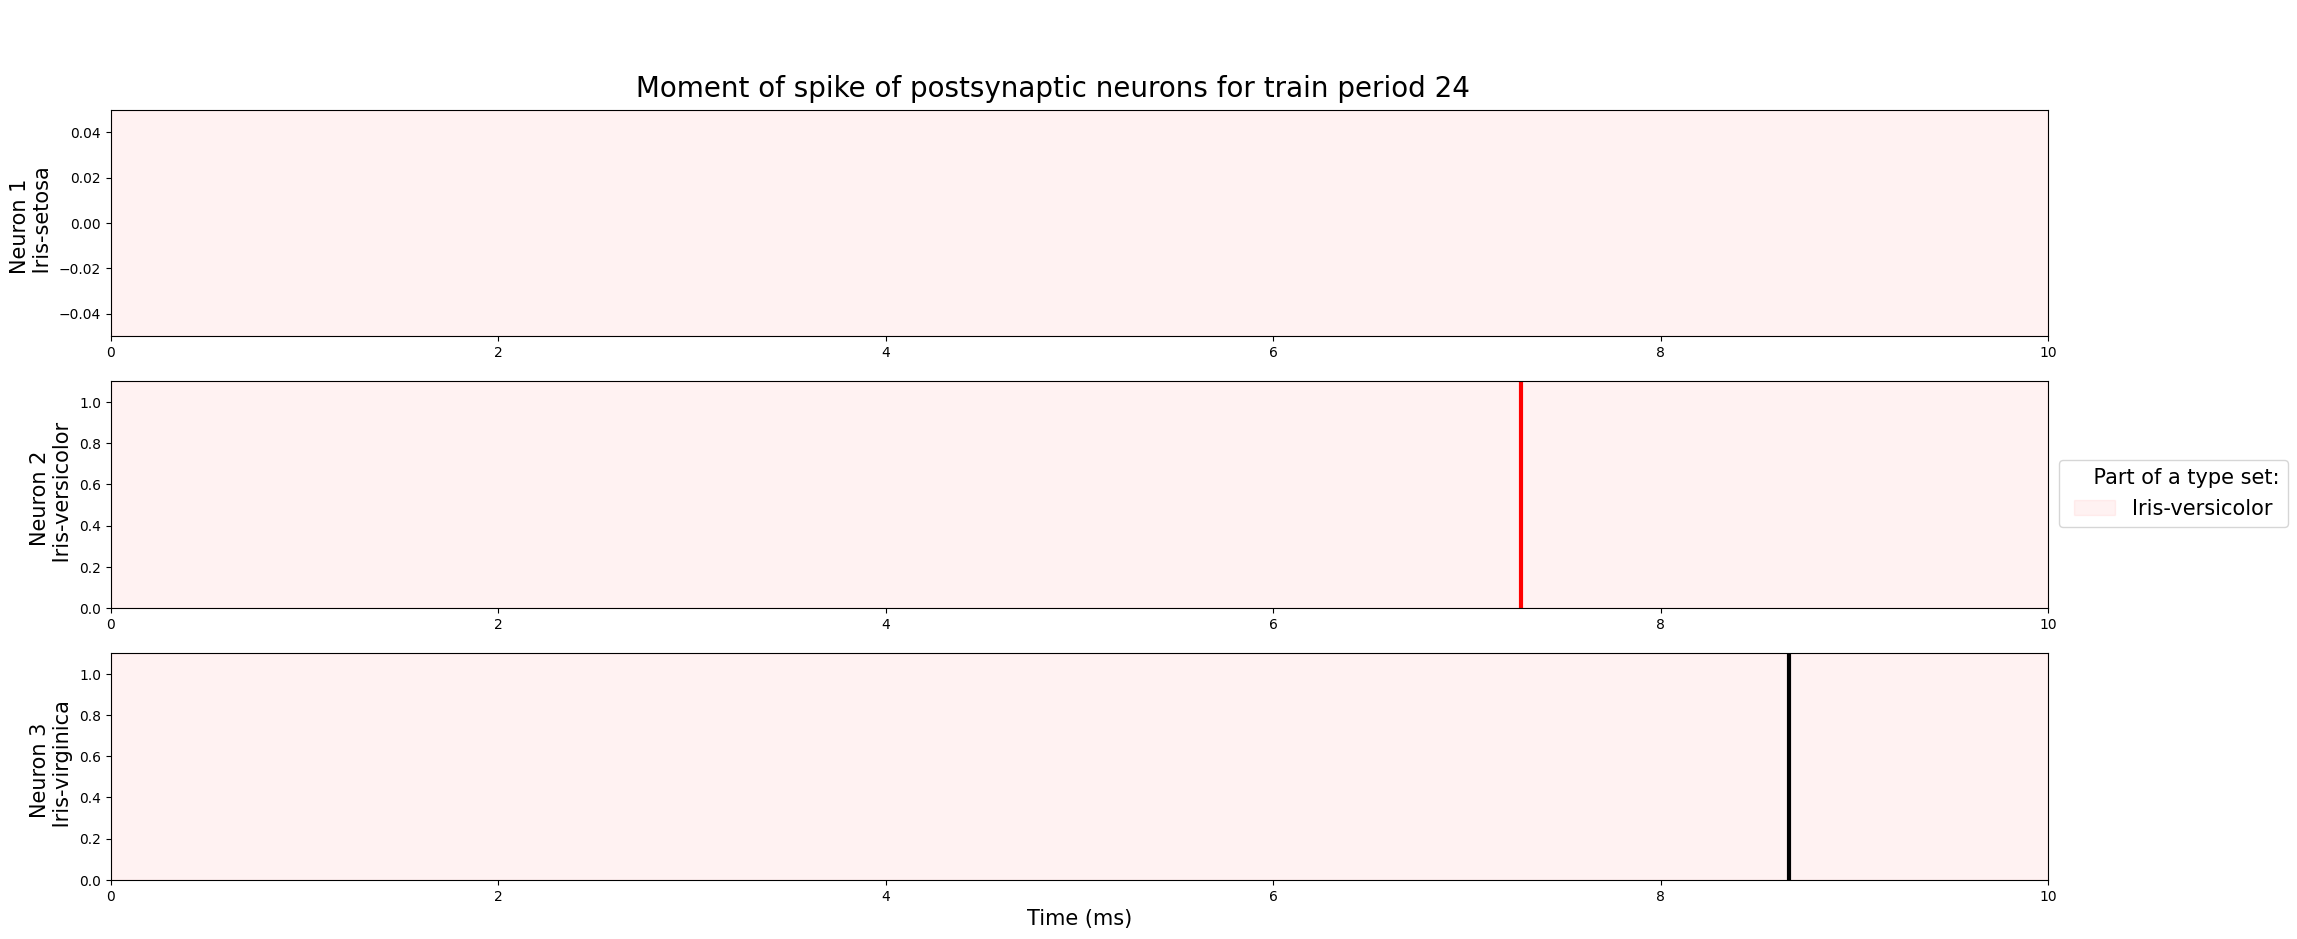

In [24]:
spike_plot(spike_time, True, 24, 2)

Together with the third spike in this period, the "correct" second postsynaptic neuron fires. In this case, because the second neuron fired earlier than the false third neuron, it will be considered as having fired in the current period and no error will occur.

Overall, things are going well, so let's smoothly transition to the second part of training. To do this, we take the next 20 examples of each type:

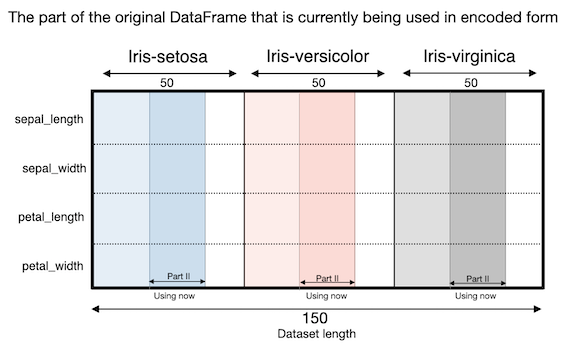

At this stage, we are training on the next set of input data using local STDP learning. Before we proceed, let's see what the result and accuracy would be if we applied the current weights to the second training set:

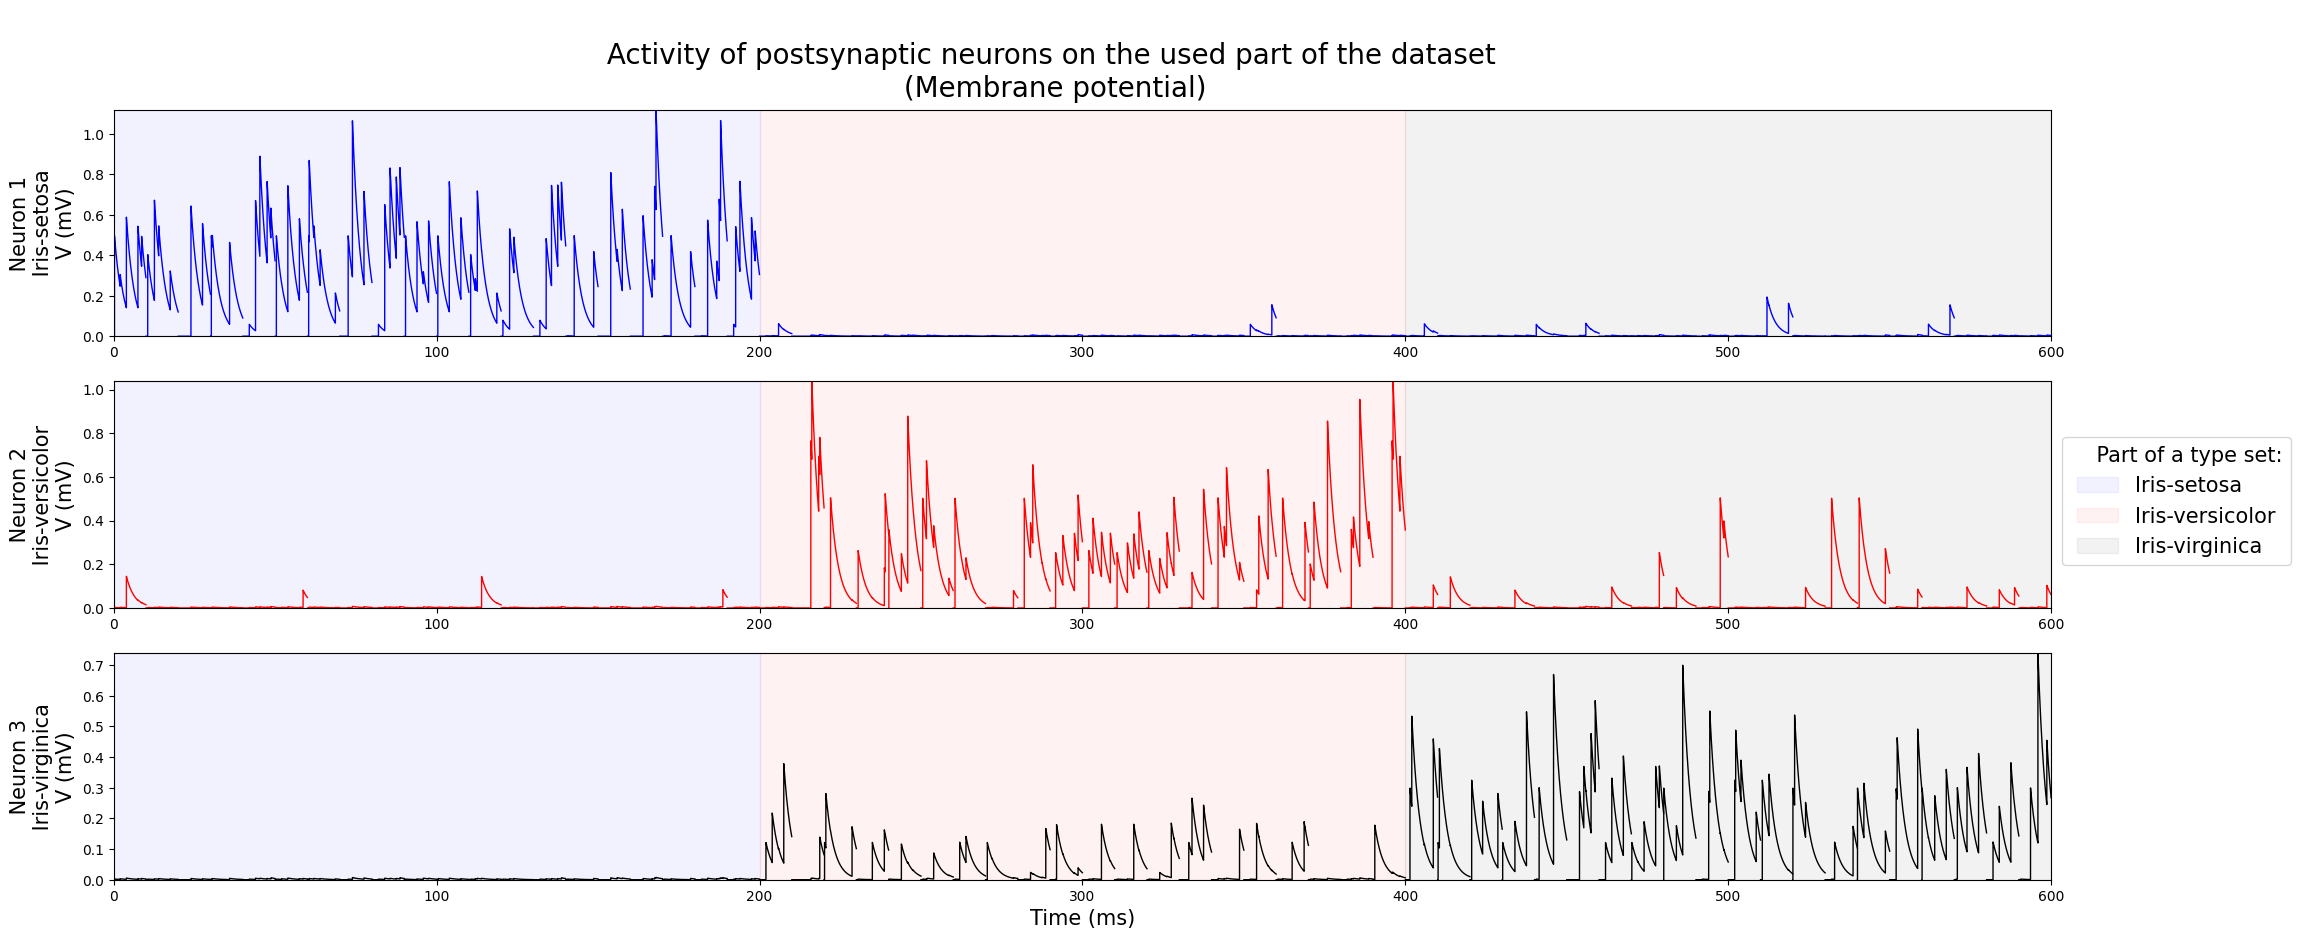

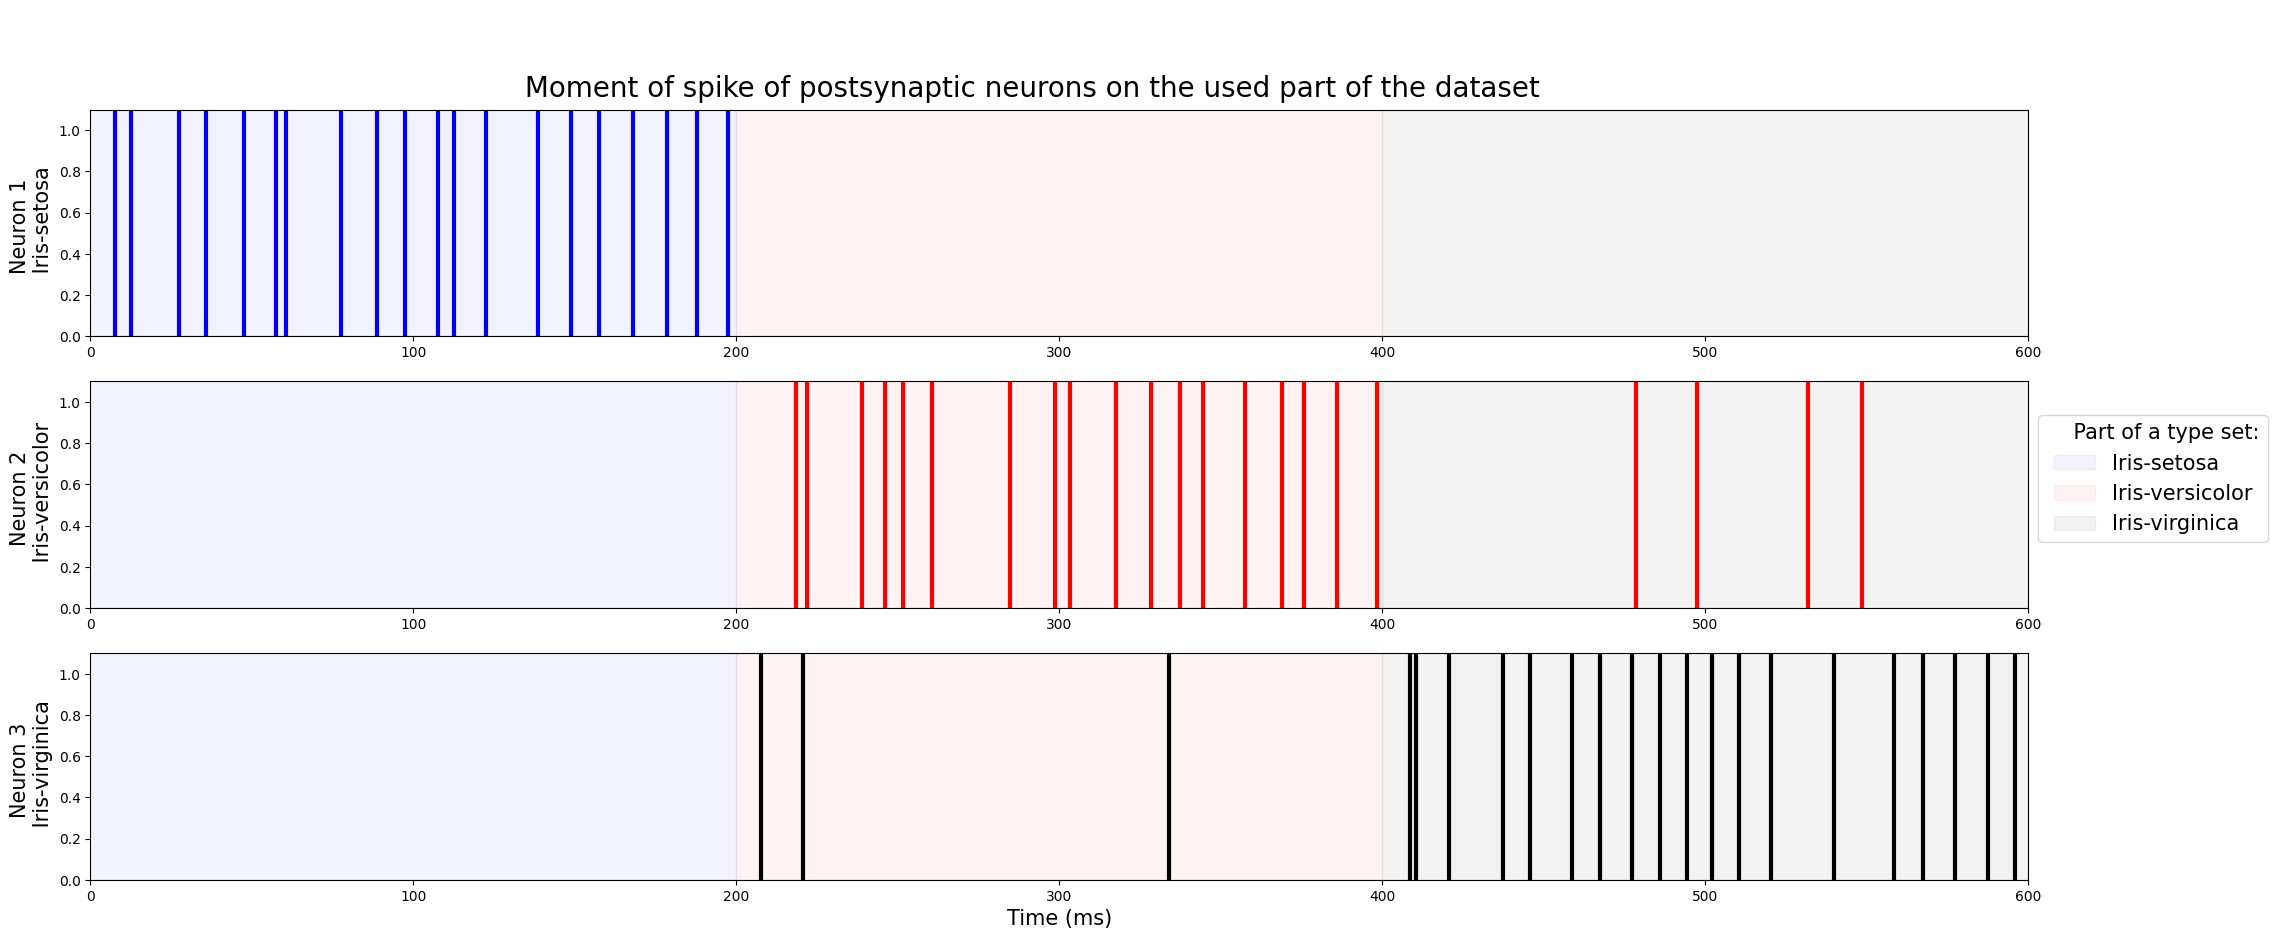

accur.: 91.67 %


In [25]:
train_stack = model_data(0, ind_type, lat_ne, 20, 40)
res = LIF_SNN(3, 60, train_stack, list_weight, 100)
v = res[0]

v_plot(v)
res = LIF_SNN(3, 60, train_stack, list_weight, 0.25)
spike_time = res[2]
spike_plot(spike_time, False, False, False)
accuracy_snn(spike_time, 20, 40, df, ind_type, 0)[2]

Overall, the profile is similar to the profile of the first set. The accuracy has slightly decreased - a expected result.

Now it's time to adjust the weights using classical STDP for the second part of the training set. A few words about the formula and meaning of the used STDP approach. In short: presynaptic neurons generate spikes -> the membrane potential of the postsynaptic neuron increases and reaches a threshold value -> the postsynaptic neuron generates a spike -> if the period has not ended, presynaptic neurons can continue to generate spikes that are no longer needed -> it is necessary to strengthen the weights of presynaptic neurons that fired **before** the postsynaptic neuron generated a spike and decrease the weights of those that fired after.

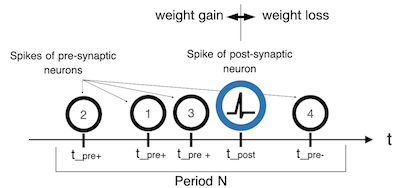

To apply STDP, we will record the spike timings of each postsynaptic neuron at a threshold value of 0.25, obtaining values for t_post. We already have the values for t_pre (latency) which we calculated earlier. We will calculate the weight change for each presynaptic neuron for each postsynaptic neuron using the following formulas:

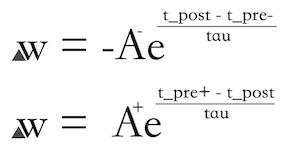

Depending on the presynaptic neuron's latency their  the weights will be adjusted towards growth or reduction. The constants A+ and A- are selected individually for each task: if the training set is large, a small value can be chosen, and vice versa for a small training set (as we have now). A+ and A- are usually expressed in terms of each other:

In [26]:
res = LIF_SNN(3, 60, train_stack, list_weight, 0.25)
t_post = res[1]
A_p = 0.8
A_m = A_p * 1.1

for n in range(3):
    for u in range(20):
        
        t1 = np.round(train_stack[u + 10 * n] * 1000)
        t2 = t1.copy()
        
        t2[((t1 <= t_post[n, u]) & (t1 > 0))] = A_p * np.exp((t1[((t1 <= t_post[n, u]) & (t1 > 0))] - t_post[n, u]) / 1000)
        t2[((t1 > t_post[n, u]) & (t1 > 0))] = - A_m * np.exp((t_post[n, u] - t1[((t1 > t_post[n, u]) & (t1 > 0))]) / 1000)
        
        list_weight[n, :] += t2
        
list_weight[list_weight < 0] = 0
list_weight

array([[6.862836, 13.145559, 11.218560, 0.000000, 0.100000, 0.100000,
        0.100000, 0.100000, 0.100000, 0.100000, 0.100000, 0.100000,
        0.100000, 0.000000, 3.468747, 8.101061, 5.357873, 9.094203,
        4.997382, 5.913790, 12.862322, 35.286996, 0.000000, 0.100000,
        0.100000, 0.100000, 0.100000, 0.100000, 0.100000, 0.100000,
        29.423158, 33.231633, 0.899200, 0.100000, 0.100000, 0.100000,
        0.100000, 0.100000, 0.100000, 0.100000],
       [0.846661, 0.000000, 0.000000, 6.742296, 2.221632, 3.825692,
        6.031482, 0.100000, 0.100000, 0.100000, 8.024717, 10.069888,
        0.891464, 2.484407, 0.000000, 0.000000, 0.000000, 0.100000,
        1.190985, 0.877911, 0.000000, 0.000000, 0.100000, 6.758999,
        12.250049, 19.518105, 2.642383, 0.100000, 0.100000, 0.100000,
        0.000000, 0.000000, 0.100000, 11.898439, 14.185231, 26.730888,
        0.000000, 0.000000, 0.100000, 0.100000],
       [0.100000, 0.100000, 0.100000, 0.000000, 0.000000, 5.184429,
      

We have adjusted the weights, let's see how the accuracy of the model has now changed on the second set of training instances:

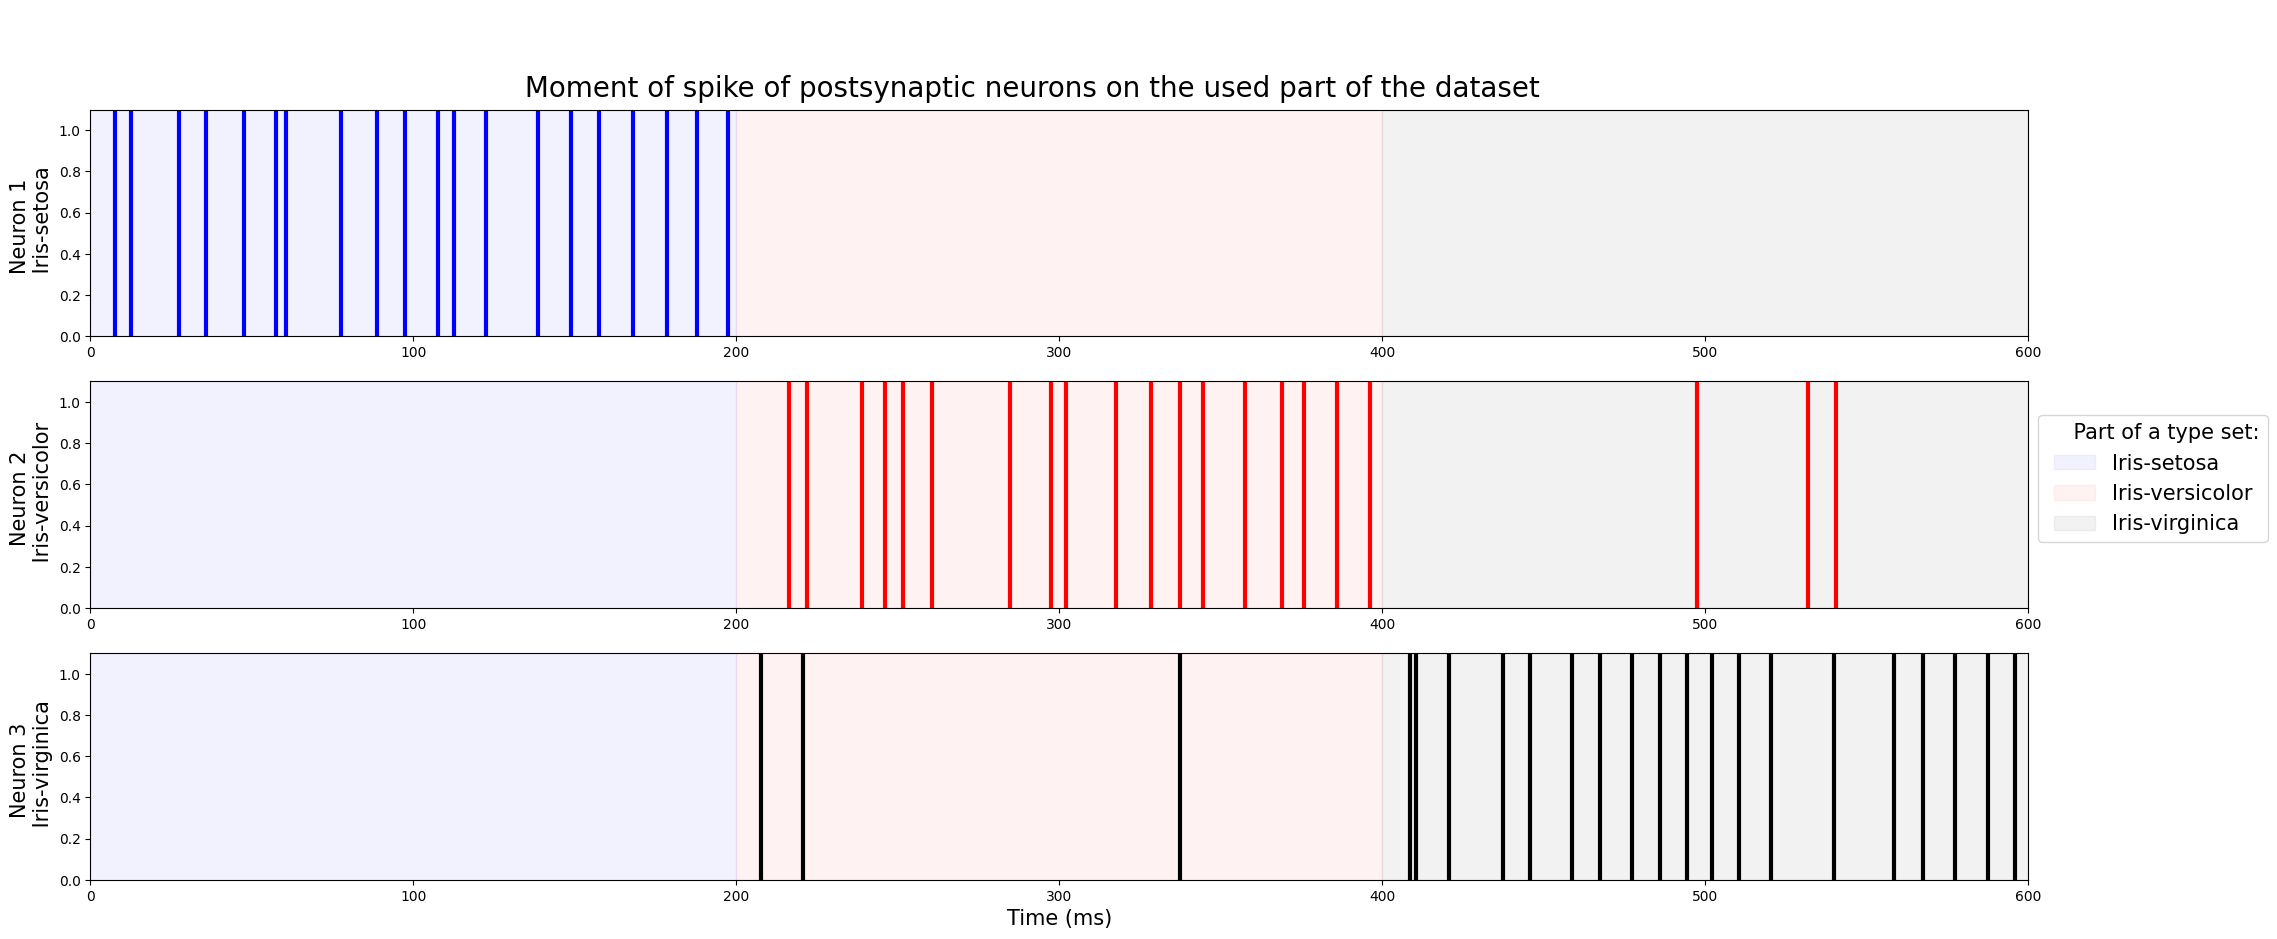

accur.: 93.33 %


In [27]:
res = LIF_SNN(3, 60, train_stack, list_weight, 0.25)
spike_time = res[2]
spike_plot(spike_time, False, False, False)
accuracy_snn(spike_time, 20, 40, df, ind_type, 0)[2]

Great! It has increased to its previous level. Now let's check the classification accuracy on the entire training set (all first 40 instances of each class) using by this weights:

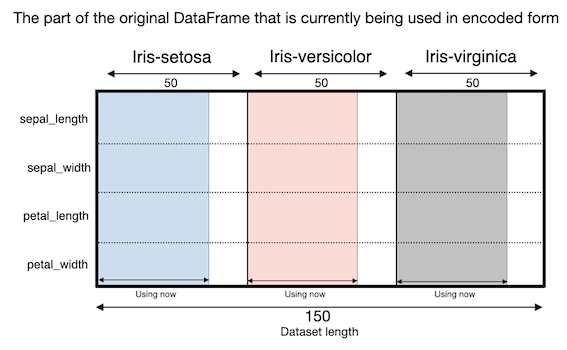

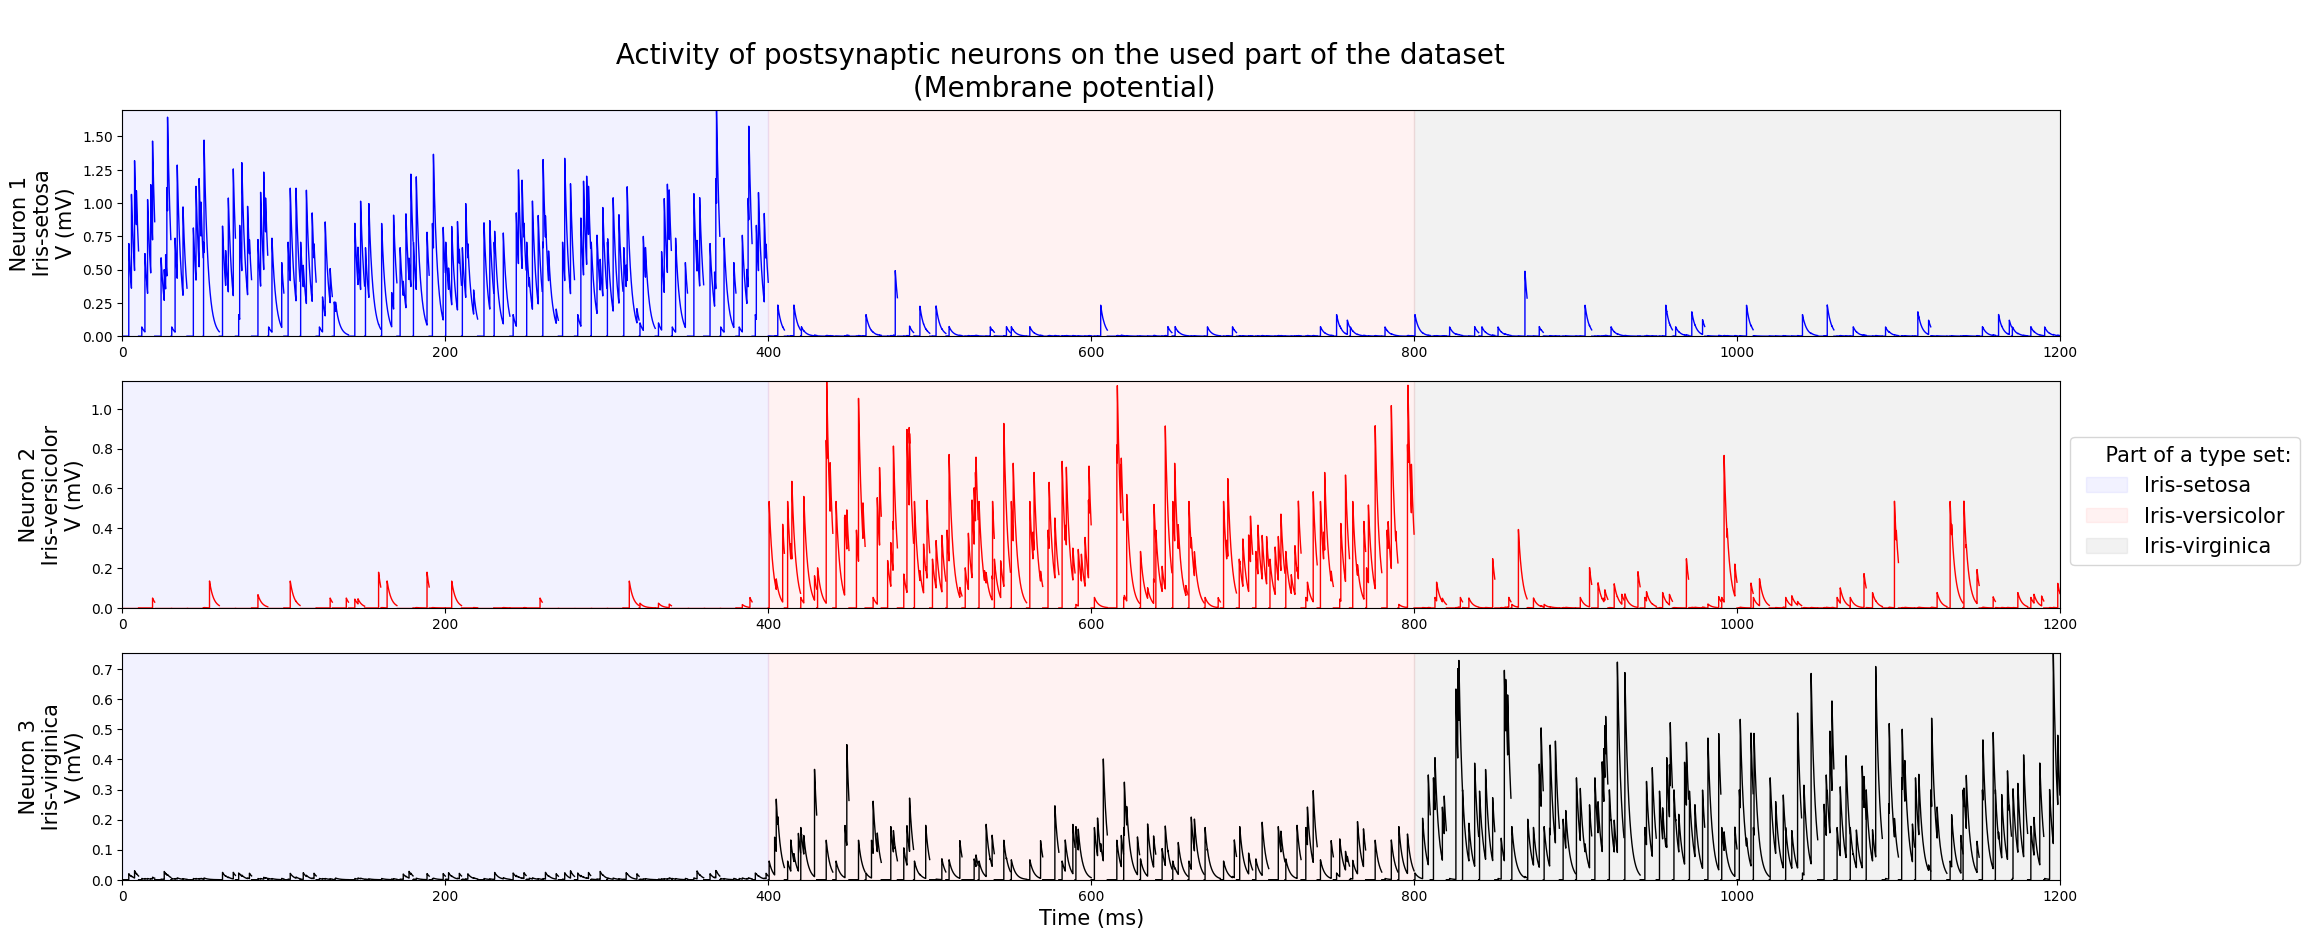

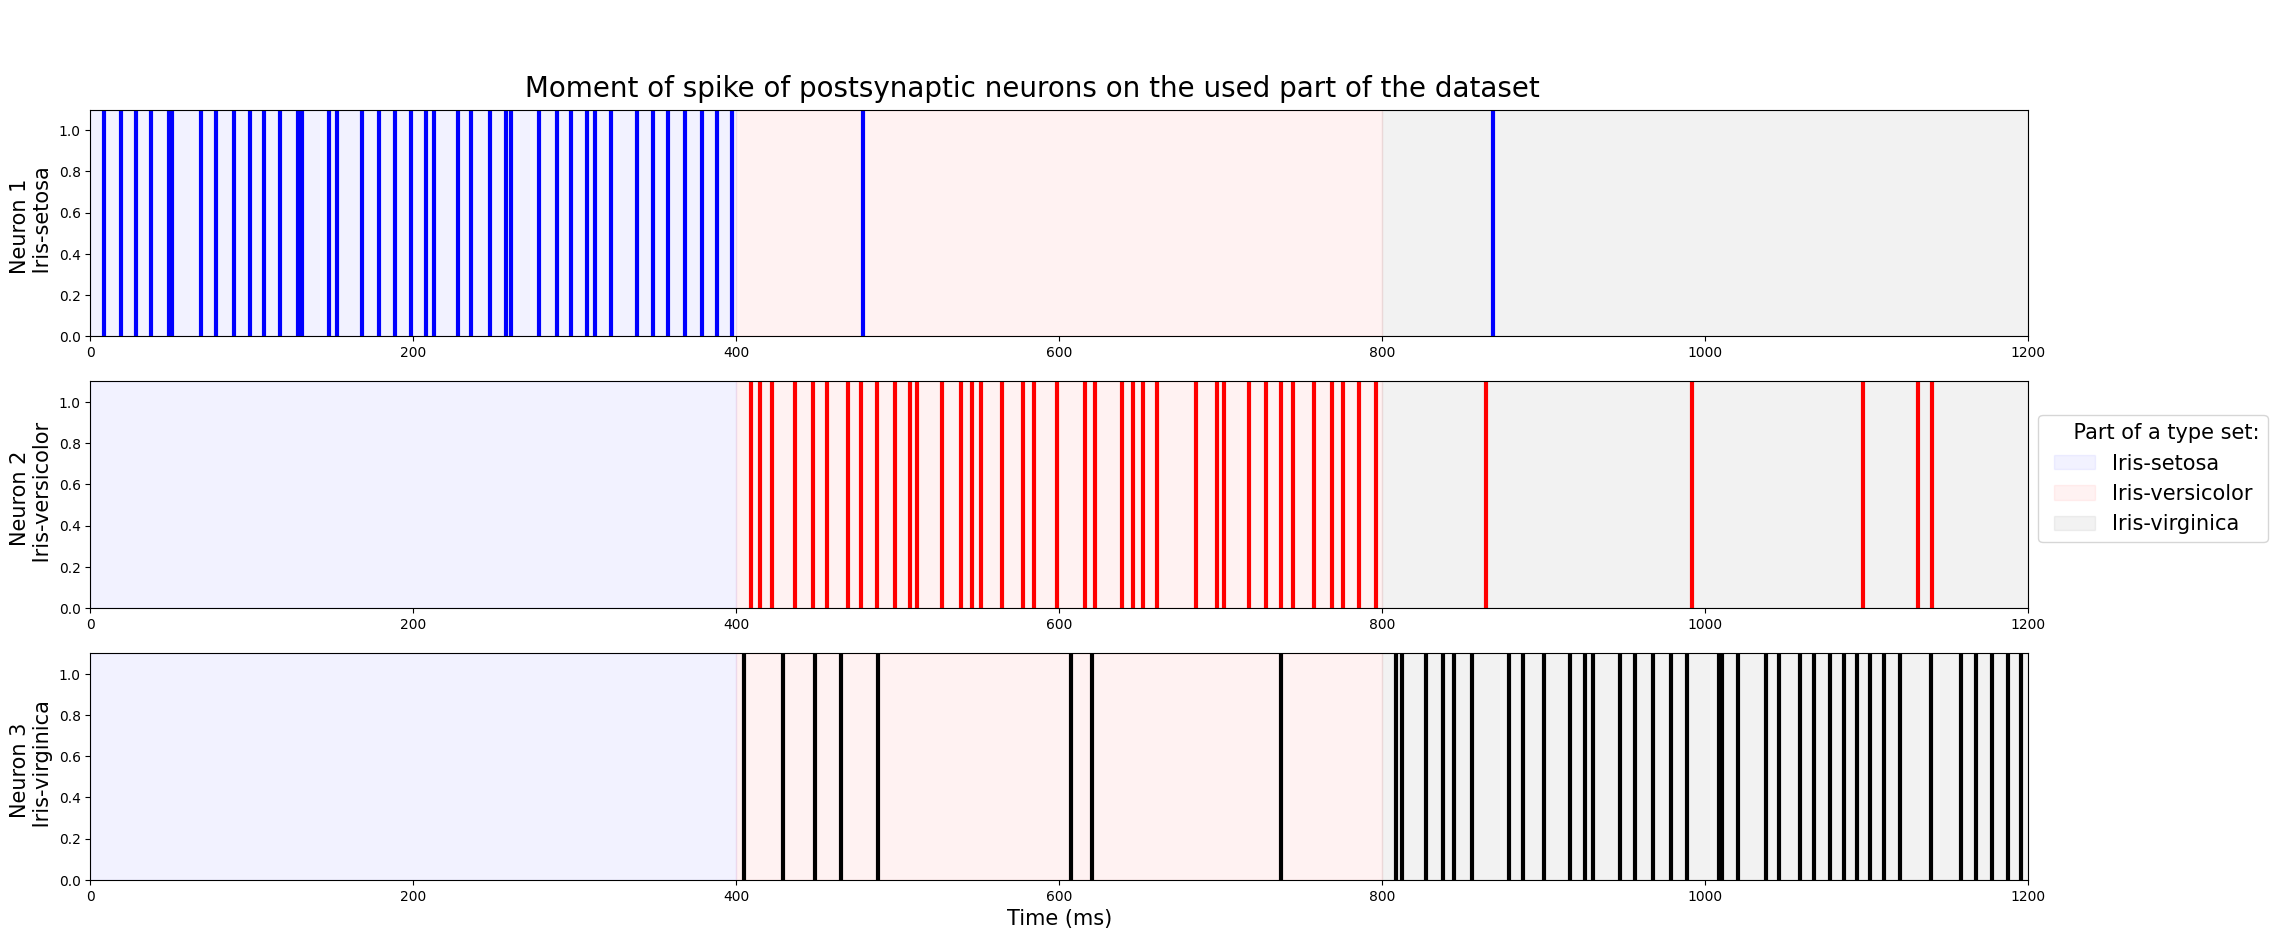

accur.: 92.5 %


In [28]:
train_stack = model_data(0, ind_type, lat_ne, 0, 40)
res = LIF_SNN(3, 120, train_stack, list_weight, 100)
v = res[0]

v_plot(v)
res = LIF_SNN(3, 120, train_stack, list_weight, 0.25)
spike_time = res[2]
spike_plot(spike_time, False, False, False)
accuracy_snn(spike_time, 0, 40, df, ind_type, 0)[2]

Overall, it's very good that the quality almost didn't decrease when the sample size was doubled. Although there are periods in which postsynaptic neurons sometimes fire at the wrong times, we still achieve high accuracy because the postsynaptic neuron that generated a spike earlier within one period is recognized as having fired.

Now let's run the network on the test set (the last 10 instances of each class):

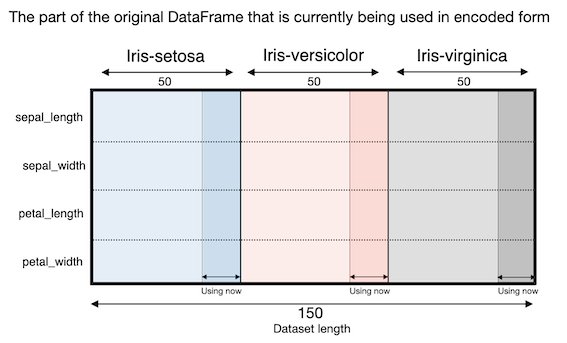

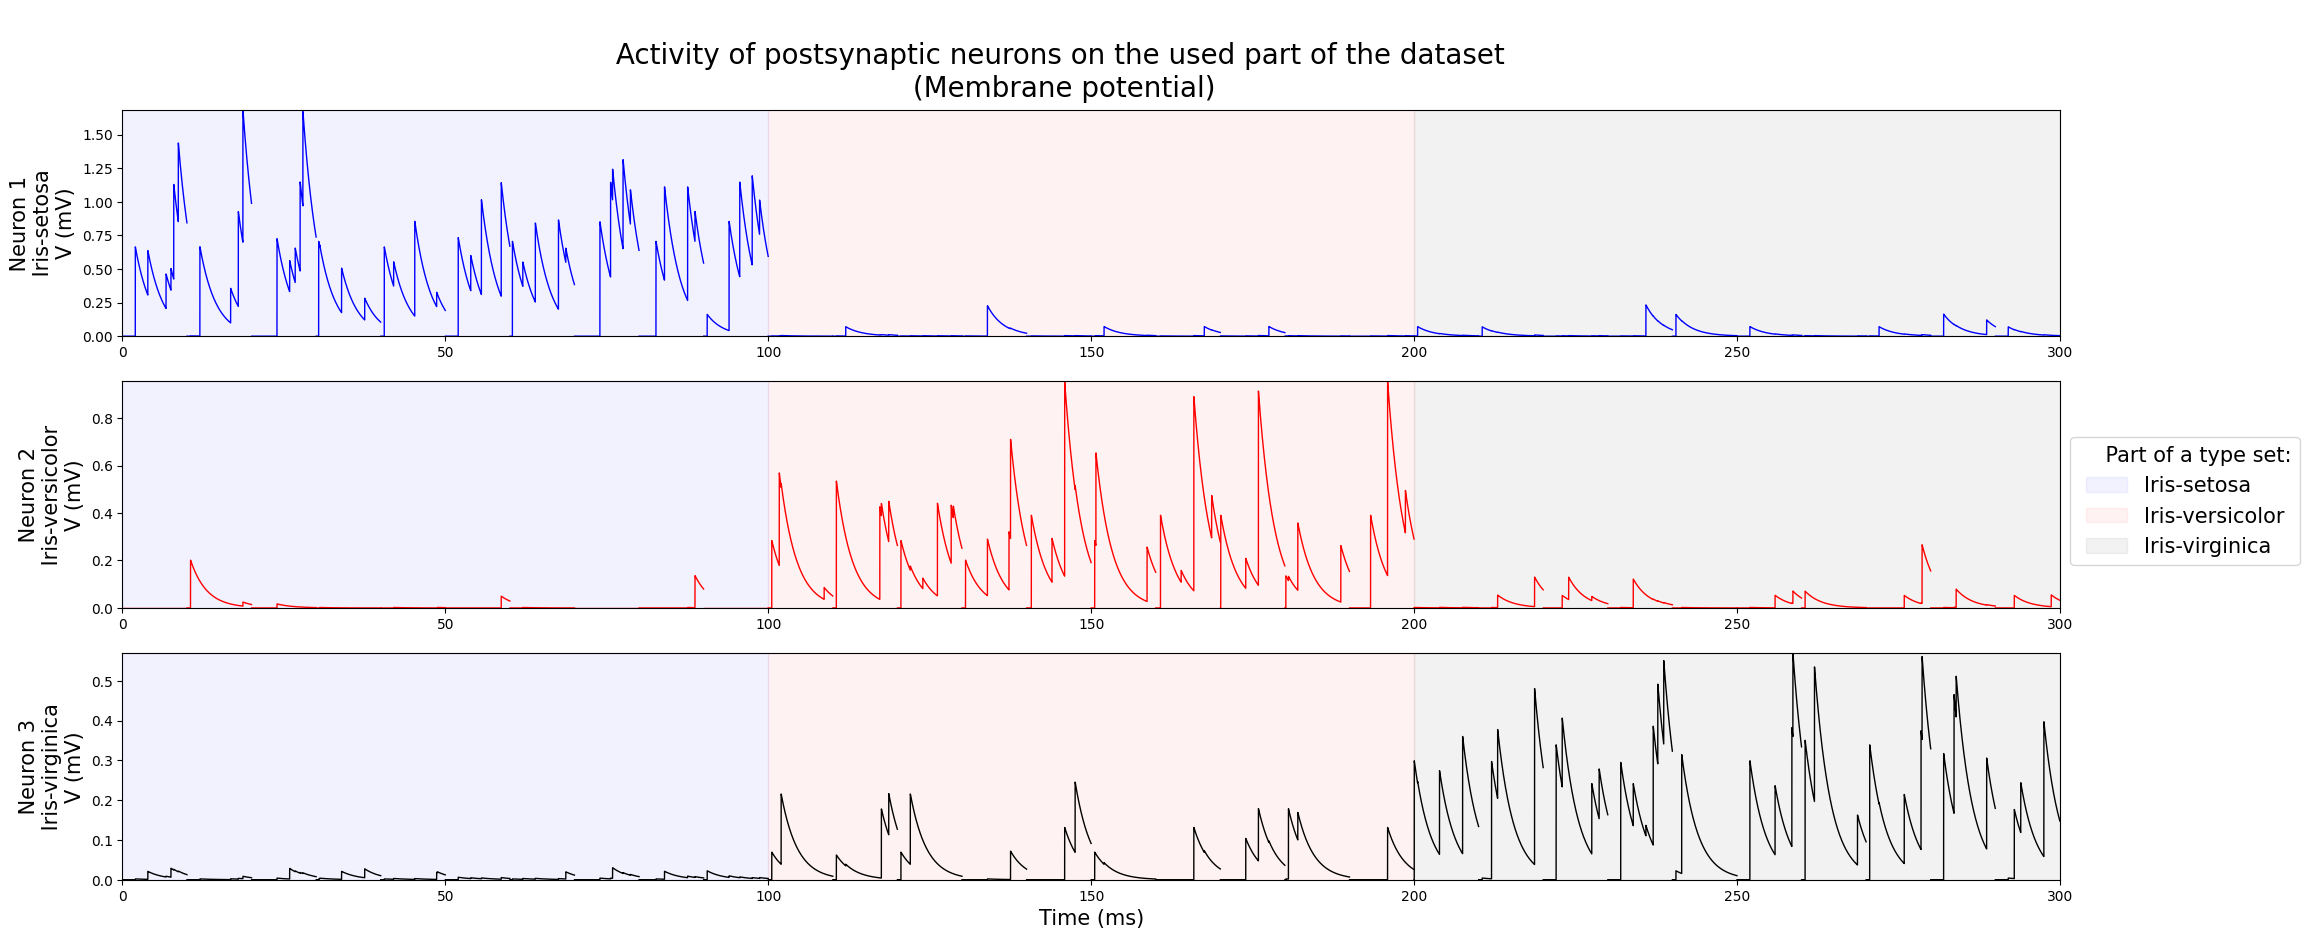

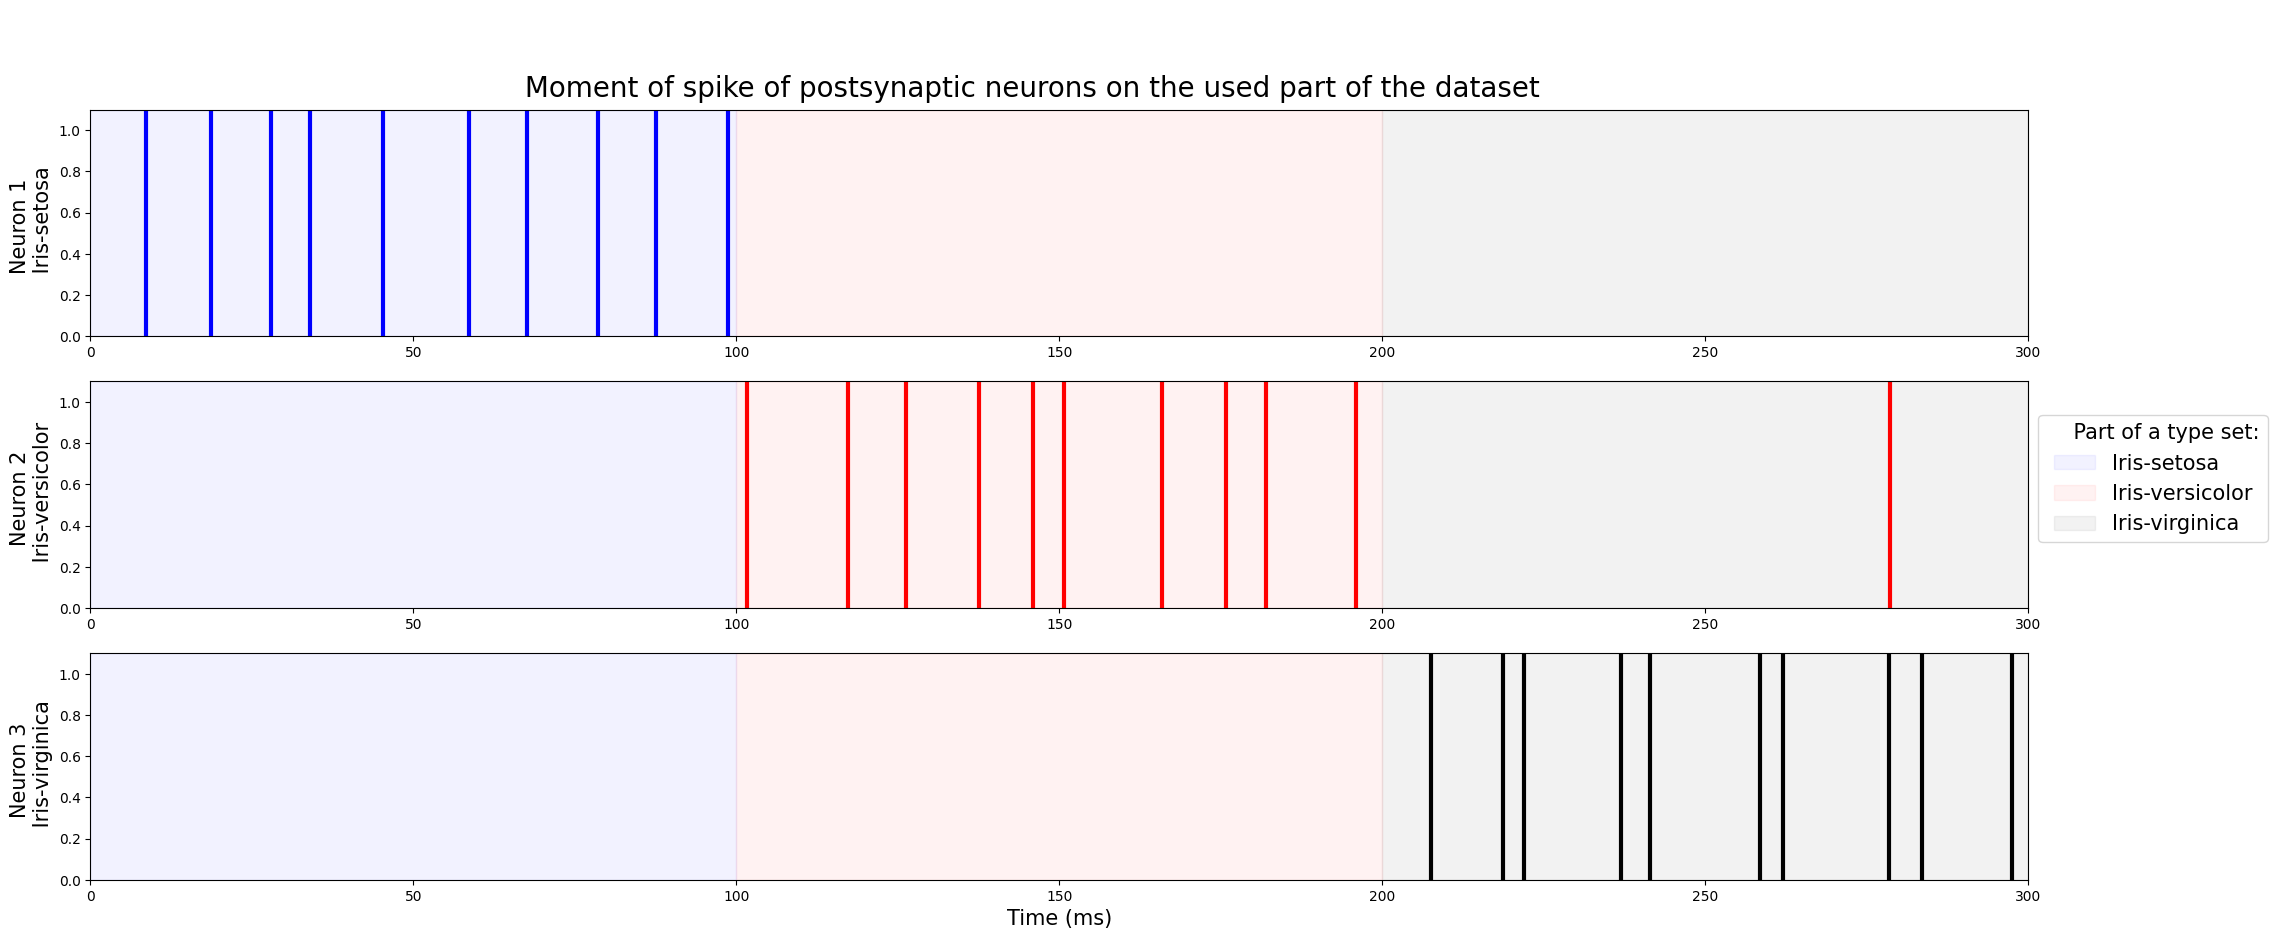

accur.: 100.0 %


In [45]:
train_stack = model_data(0, ind_type, lat_ne, 40, 50)
res = LIF_SNN(3, 30, train_stack, list_weight, 100)
v = res[0]
res = LIF_SNN(3, 30, train_stack, list_weight, 0.25)
spike_time = res[2]

v_plot(v)
spike_plot(spike_time, False, False, False)
accuracy_snn(spike_time, 40, 50, df, ind_type, 0)[2]

Accuracy is 100%! 

There seems to be one false firing of the second postsynaptic neuron in period 27, let's examine it more closely:

In [ ]:
spike_plot(spike_time, True, 27, 3)

In this case, due to the fact that the third postsynaptic neuron fired before the false second one (8.50 mc vs 8.66 ms), it is considered to have fired in the current period and no error will occur.

Congratulations! we wrote a simple impulse neural model from scratch and learned how to encode data using Gaussian receptive fields using only NumPy.

**References**:

[1] Alexander Sboev, Danila Vlasov, Roman Rybka, Alexey Serenko, "[Spiking neural network reinforcement learning method based on Abstract temporal coding and STDP](https://www.sciencedirect.com/science/article/pii/S1877050918323950)", Procedia Computer Science Volume 145, 2018, Pages 458-463

[2] Stefan Schliebs, Nikola Kasabov, "[Evolving spiking neural networks: A Survey](https://www.researchgate.net/publication/257786595_Evolving_spiking_neural_networks_A_Survey)", Article in Evolving Systems, June 2013 DOI: 10.1007/s12530-013-9074-9

[3] Sander M. Bohte, Joost N. Kok, Han La Poutre, "[Error-backpropagation in temporally encoded networks of spiking neurons](https://homepages.cwi.nl/~sbohte/publication/backprop.pdf)", Neurocomputing 48 (2002) 17–37

[4] S. M. Bohte, H. La Poutre and J. N. Kok, "[Unsupervised clustering with spiking neurons by sparse temporal coding and multilayer RBF networks](https://ieeexplore.ieee.org/document/991428)" in IEEE Transactions on Neural Networks, vol. 13, no. 2, pp. 426-435, March 2002, doi: 10.1109/72.991428

[5] M. Kiselev, "Spiking neural networks - Information Representation, Learning, Memory" (manuscript)

[6] Eugene M. Izhikevich, "[Simple Model of Spiking Neurons](https://www.izhikevich.org/publications/spikes.pdf)", IEEE TRANSACTIONS ON NEURAL NETWORKS, VOL. 14, NO. 6, NOVEMBER 2003

[7] Dmitry Ivanov, Aleksandr Chezhegov, Mikhail Kiselev, Andrey Grunin, Denis Larionov, "[Neuromorphic artificial intelligence systems](https://www.frontiersin.org/articles/10.3389/fnins.2022.959626/full)", Front. Neurosci., 14 September 2022, Sec. Neuromorphic Engineering, Volume 16 - 2022

[8] Laurent U Perrinet, Arnaud Delorme, Manuel Samuelides, Simon Jonathan Thorpe, "[Networks of Integrate-and-Fire Neuron using Rank Order Coding A: How to Implement Spike Time Dependent Hebbian Plasticity](https://www.researchgate.net/publication/220551941_Networks_of_Integrate-and-Fire_Neuron_using_Rank_Order_Coding_A_How_to_Implement_Spike_Time_Dependent_Hebbian_Plasticity)", June 2001, Neurocomputing 38-40:817-822, DOI:10.1016/S0925-2312(01)00460-X

[9] Senglan Li, Qiang Yu, "[New Efficient Multi-Spike Learning for Fast Processing and Robust Learning](https://www.researchgate.net/publication/342543443_New_Efficient_Multi-Spike_Learning_for_Fast_Processing_and_Robust_Learning)", April 2020Proceedings of the AAAI Conference on Artificial Intelligence 34(04):4650-4657, DOI:10.1609/aaai.v34i04.5896

[10] Gütig R, Sompolinsky H., "[The tempotron: a neuron that learns spike timing-based decisions](https://pubmed.ncbi.nlm.nih.gov/16474393/)", Nat Neurosci. 2006 Mar;9(3):420-8. doi: 10.1038/nn1643. Epub 2006 Feb 12. PMID: 16474393.

[11] Baktash Babadi, L. F. Abbott, "[Stability and Competition in Multi-spike Models of Spike-Timing Dependent Plasticity](https://journals.plos.org/ploscompbiol/article?id=10.1371/journal.pcbi.1004750)", Published: March 3, 2016, https://doi.org/10.1371/journal.pcbi.1004750

[12] [Neuromatch Academy: Computational Neuroscience](https://compneuro.neuromatch.io/tutorials/intro.html)

[13] Zexiang Yi, Jing Lian, Qidong Liu, Hegui Zhu, Dong Liang, Jizhao Liu, "[Learning rules in spiking neural networks: A survey](https://www.sciencedirect.com/science/article/abs/pii/S0925231223001662)", Neurocomputing, February 2023 DOI: 10.1016/j.neucom.2023.02.026